# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

In [2]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 11102019 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6c10048280>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6c10048430>)


In [3]:
# simple function to save and view results
import pickle
def save_data(data,file_name):
    with open(file_name,'wb') as f:
        pickle.dump(data,f)
    print('save successfully')
def load_data(file_name):
    with open(file_name,'rb') as f:
        data = pickle.load(f)
    print('load successfully')
    return data

In [ ]:
# 32, 64, 128 ReLU hidden units
# 100 epoch
# AdamLearningRule default learning rate: 1e-03
# One hidden layer

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

#setup hyperparameters
# Uncomment below to train for different learning_rate
num_epochs = 100
stats_interval = 1
input_dim, output_dim = 784, 47
hidden_dims = [32, 64, 128]

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

for hidden_dim in hidden_dims:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    #Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook = True)

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])
    
    # Add figure title
    fig_1.suptitle('Error for network with {} hidden units'.format(hidden_dim))
    fig_2.suptitle('Accuracy for network {} hidden units'.format(hidden_dim))
    # Save figure as Pdf
    fig_1.savefig('plots/{}_hidden_units(Err).pdf'.format(hidden_dim))
    fig_2.savefig('plots/{}_hidden_units(Acc).pdf'.format(hidden_dim))
    
plt.show()

j = 0
for hidden_dim in hidden_dims:
    results = {'Number of ReLU hidden units':hidden_dim,
               'Number of epochs':num_epochs,
               'Defualt learning_rate': 1e-3,
               'Number of Hidden units':hidden_dim,
               'final error(train)':final_errors_train[j],
               'final error(valid)':final_errors_valid[j],
               'final acc(train)':final_accs_train[j],
               'final acc(valid)':final_accs_valid[j]
              }
    save_data(results,'stats/{0:3d}_hidden_units.npy'.format(j+1))
    j += 1

In [ ]:
# Define three model with different number of hidden layers : 1,2,3
models = [MultipleLayerModel([
            AffineLayer(input_dim, hidden_dim, weights_init, biases_init),  # input layer
            ReluLayer(),
            AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 1
            ReluLayer(),
            AffineLayer(hidden_dim, output_dim, weights_init, biases_init)]), # output layer
         MultipleLayerModel([
            AffineLayer(input_dim, hidden_dim, weights_init, biases_init), # input layer
            ReluLayer(),
            AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 1
            ReluLayer(),
            AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 2
            ReluLayer(),
            AffineLayer(hidden_dim, output_dim, weights_init, biases_init)]), # output layer
         MultipleLayerModel([
            AffineLayer(input_dim, hidden_dim, weights_init, biases_init),  # input layer
            ReluLayer(),
            AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 1
            ReluLayer(),
            AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 2
            ReluLayer(),
            AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 3
            ReluLayer(),
            AffineLayer(hidden_dim, output_dim, weights_init, biases_init)]) # output layer
        ]


In [ ]:
# 128 ReLU hidden units
# 100 epoch
# AdamLearningRule default learning rate: 1e-03
# Hidden layers: 1,2,3

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

#setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

for model in models:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    
    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    #Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook = True)
    
    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])
    
    # Add figure title
    fig_1.suptitle('Error for network with {} hidden layers'.format(models.index(model)+1))
    fig_2.suptitle('Accuracy for network with{} hidden layes'.format(models.index(model)+1))
    # Save figure as Pdf
    fig_1.savefig('plots/{}_hidden_layers(Err).pdf'.format(models.index(model)+1))
    fig_2.savefig('plots/{}_hidden_layers(Acc).pdf'.format(models.index(model)+1))
    
plt.show()

j = 0
for model in models:
    results = {'Number of ReLU hidden units':hidden_dim,
               'Number of epochs':num_epochs,
               'Defualt learning_rate': 1e-3,
               'Number of Hidden layers':j+1,
               'final error(train)':final_errors_train[j],
               'final error(valid)':final_errors_valid[j],
               'final acc(train)':final_accs_train[j],
               'final acc(valid)':final_accs_valid[j]
              }
    save_data(results,'stats/{0:3d}_hidden_layers.npy'.format(j+1))
    j += 1

Epoch 1: 8.0s to complete
    error(train)=7.80e-01, acc(train)=7.56e-01, error(valid)=8.02e-01, acc(valid)=7.51e-01


Epoch 2: 8.1s to complete
    error(train)=5.97e-01, acc(train)=8.04e-01, error(valid)=6.30e-01, acc(valid)=7.94e-01


Epoch 3: 7.9s to complete
    error(train)=5.75e-01, acc(train)=8.11e-01, error(valid)=6.13e-01, acc(valid)=8.01e-01


Epoch 4: 8.1s to complete
    error(train)=5.14e-01, acc(train)=8.23e-01, error(valid)=5.51e-01, acc(valid)=8.15e-01


Epoch 5: 8.0s to complete
    error(train)=5.07e-01, acc(train)=8.27e-01, error(valid)=5.50e-01, acc(valid)=8.15e-01


Epoch 6: 8.0s to complete
    error(train)=4.80e-01, acc(train)=8.36e-01, error(valid)=5.25e-01, acc(valid)=8.23e-01


Epoch 7: 8.4s to complete
    error(train)=4.71e-01, acc(train)=8.40e-01, error(valid)=5.20e-01, acc(valid)=8.26e-01


Epoch 8: 8.1s to complete
    error(train)=4.43e-01, acc(train)=8.47e-01, error(valid)=4.95e-01, acc(valid)=8.35e-01


Epoch 9: 8.2s to complete
    error(train)=4.27e-01, acc(train)=8.51e-01, error(valid)=4.72e-01, acc(valid)=8.38e-01


Epoch 10: 8.0s to complete
    error(train)=4.37e-01, acc(train)=8.47e-01, error(valid)=4.92e-01, acc(valid)=8.33e-01


Epoch 11: 8.1s to complete
    error(train)=4.53e-01, acc(train)=8.44e-01, error(valid)=5.03e-01, acc(valid)=8.28e-01


Epoch 12: 7.9s to complete
    error(train)=4.27e-01, acc(train)=8.51e-01, error(valid)=4.82e-01, acc(valid)=8.38e-01


Epoch 13: 7.7s to complete
    error(train)=4.23e-01, acc(train)=8.52e-01, error(valid)=4.81e-01, acc(valid)=8.36e-01


Epoch 14: 7.8s to complete
    error(train)=4.25e-01, acc(train)=8.52e-01, error(valid)=4.79e-01, acc(valid)=8.38e-01


Epoch 15: 8.3s to complete
    error(train)=4.07e-01, acc(train)=8.59e-01, error(valid)=4.62e-01, acc(valid)=8.43e-01


Epoch 16: 7.7s to complete
    error(train)=3.98e-01, acc(train)=8.60e-01, error(valid)=4.54e-01, acc(valid)=8.46e-01


Epoch 17: 8.0s to complete
    error(train)=4.23e-01, acc(train)=8.53e-01, error(valid)=4.87e-01, acc(valid)=8.35e-01


Epoch 18: 7.9s to complete
    error(train)=3.95e-01, acc(train)=8.60e-01, error(valid)=4.55e-01, acc(valid)=8.45e-01


Epoch 19: 8.0s to complete
    error(train)=3.98e-01, acc(train)=8.61e-01, error(valid)=4.62e-01, acc(valid)=8.40e-01


Epoch 20: 7.8s to complete
    error(train)=3.95e-01, acc(train)=8.59e-01, error(valid)=4.60e-01, acc(valid)=8.43e-01


Epoch 21: 8.0s to complete
    error(train)=3.83e-01, acc(train)=8.66e-01, error(valid)=4.51e-01, acc(valid)=8.47e-01


Epoch 22: 8.1s to complete
    error(train)=3.90e-01, acc(train)=8.61e-01, error(valid)=4.52e-01, acc(valid)=8.44e-01


Epoch 23: 8.2s to complete
    error(train)=4.09e-01, acc(train)=8.53e-01, error(valid)=4.75e-01, acc(valid)=8.38e-01


Epoch 24: 8.1s to complete
    error(train)=3.73e-01, acc(train)=8.67e-01, error(valid)=4.33e-01, acc(valid)=8.49e-01


Epoch 25: 7.9s to complete
    error(train)=4.08e-01, acc(train)=8.55e-01, error(valid)=4.73e-01, acc(valid)=8.35e-01


Epoch 26: 8.1s to complete
    error(train)=3.79e-01, acc(train)=8.65e-01, error(valid)=4.50e-01, acc(valid)=8.44e-01


Epoch 27: 8.2s to complete
    error(train)=3.86e-01, acc(train)=8.58e-01, error(valid)=4.58e-01, acc(valid)=8.39e-01


Epoch 28: 8.3s to complete
    error(train)=3.84e-01, acc(train)=8.62e-01, error(valid)=4.55e-01, acc(valid)=8.44e-01


Epoch 29: 8.1s to complete
    error(train)=3.78e-01, acc(train)=8.64e-01, error(valid)=4.46e-01, acc(valid)=8.47e-01


Epoch 30: 8.3s to complete
    error(train)=3.86e-01, acc(train)=8.61e-01, error(valid)=4.57e-01, acc(valid)=8.44e-01


Epoch 31: 8.6s to complete
    error(train)=3.70e-01, acc(train)=8.69e-01, error(valid)=4.39e-01, acc(valid)=8.50e-01


Epoch 32: 8.6s to complete
    error(train)=3.63e-01, acc(train)=8.70e-01, error(valid)=4.38e-01, acc(valid)=8.51e-01


Epoch 33: 8.9s to complete
    error(train)=3.58e-01, acc(train)=8.73e-01, error(valid)=4.34e-01, acc(valid)=8.53e-01


Epoch 34: 8.8s to complete
    error(train)=3.72e-01, acc(train)=8.65e-01, error(valid)=4.48e-01, acc(valid)=8.47e-01


Epoch 35: 9.0s to complete
    error(train)=3.67e-01, acc(train)=8.67e-01, error(valid)=4.43e-01, acc(valid)=8.46e-01


Epoch 36: 9.2s to complete
    error(train)=3.59e-01, acc(train)=8.71e-01, error(valid)=4.39e-01, acc(valid)=8.48e-01


Epoch 37: 9.8s to complete
    error(train)=3.65e-01, acc(train)=8.67e-01, error(valid)=4.44e-01, acc(valid)=8.45e-01


Epoch 38: 8.7s to complete
    error(train)=3.64e-01, acc(train)=8.67e-01, error(valid)=4.43e-01, acc(valid)=8.46e-01


Epoch 39: 8.2s to complete
    error(train)=3.63e-01, acc(train)=8.68e-01, error(valid)=4.41e-01, acc(valid)=8.47e-01


Epoch 40: 7.8s to complete
    error(train)=3.61e-01, acc(train)=8.69e-01, error(valid)=4.39e-01, acc(valid)=8.48e-01


Epoch 41: 7.9s to complete
    error(train)=3.54e-01, acc(train)=8.72e-01, error(valid)=4.35e-01, acc(valid)=8.51e-01


Epoch 42: 8.3s to complete
    error(train)=3.64e-01, acc(train)=8.67e-01, error(valid)=4.45e-01, acc(valid)=8.46e-01


Epoch 43: 8.1s to complete
    error(train)=3.57e-01, acc(train)=8.69e-01, error(valid)=4.36e-01, acc(valid)=8.48e-01


Epoch 44: 8.3s to complete
    error(train)=3.49e-01, acc(train)=8.75e-01, error(valid)=4.27e-01, acc(valid)=8.55e-01


Epoch 45: 8.0s to complete
    error(train)=3.60e-01, acc(train)=8.70e-01, error(valid)=4.46e-01, acc(valid)=8.47e-01


Epoch 46: 7.9s to complete
    error(train)=3.67e-01, acc(train)=8.68e-01, error(valid)=4.43e-01, acc(valid)=8.48e-01


Epoch 47: 8.2s to complete
    error(train)=3.61e-01, acc(train)=8.71e-01, error(valid)=4.44e-01, acc(valid)=8.49e-01


Epoch 48: 7.9s to complete
    error(train)=3.57e-01, acc(train)=8.71e-01, error(valid)=4.40e-01, acc(valid)=8.45e-01


Epoch 49: 8.2s to complete
    error(train)=3.56e-01, acc(train)=8.70e-01, error(valid)=4.41e-01, acc(valid)=8.46e-01


Epoch 50: 8.6s to complete
    error(train)=3.54e-01, acc(train)=8.72e-01, error(valid)=4.34e-01, acc(valid)=8.51e-01


Epoch 51: 8.0s to complete
    error(train)=3.45e-01, acc(train)=8.76e-01, error(valid)=4.32e-01, acc(valid)=8.53e-01


Epoch 52: 7.9s to complete
    error(train)=3.55e-01, acc(train)=8.72e-01, error(valid)=4.36e-01, acc(valid)=8.50e-01


Epoch 53: 8.4s to complete
    error(train)=3.54e-01, acc(train)=8.71e-01, error(valid)=4.39e-01, acc(valid)=8.50e-01


Epoch 54: 8.2s to complete
    error(train)=3.60e-01, acc(train)=8.70e-01, error(valid)=4.43e-01, acc(valid)=8.47e-01


Epoch 55: 8.2s to complete
    error(train)=3.47e-01, acc(train)=8.75e-01, error(valid)=4.32e-01, acc(valid)=8.52e-01


Epoch 56: 8.2s to complete
    error(train)=3.47e-01, acc(train)=8.75e-01, error(valid)=4.32e-01, acc(valid)=8.52e-01


Epoch 57: 7.9s to complete
    error(train)=3.42e-01, acc(train)=8.76e-01, error(valid)=4.29e-01, acc(valid)=8.54e-01


Epoch 58: 8.2s to complete
    error(train)=3.52e-01, acc(train)=8.72e-01, error(valid)=4.40e-01, acc(valid)=8.49e-01


Epoch 59: 8.5s to complete
    error(train)=3.47e-01, acc(train)=8.75e-01, error(valid)=4.32e-01, acc(valid)=8.53e-01


Epoch 60: 8.2s to complete
    error(train)=3.42e-01, acc(train)=8.75e-01, error(valid)=4.33e-01, acc(valid)=8.50e-01


Epoch 61: 8.2s to complete
    error(train)=3.37e-01, acc(train)=8.77e-01, error(valid)=4.21e-01, acc(valid)=8.53e-01


Epoch 62: 8.0s to complete
    error(train)=3.47e-01, acc(train)=8.71e-01, error(valid)=4.44e-01, acc(valid)=8.44e-01


Epoch 63: 8.3s to complete
    error(train)=3.47e-01, acc(train)=8.76e-01, error(valid)=4.34e-01, acc(valid)=8.52e-01


Epoch 64: 8.2s to complete
    error(train)=3.42e-01, acc(train)=8.76e-01, error(valid)=4.29e-01, acc(valid)=8.52e-01


Epoch 65: 8.2s to complete
    error(train)=3.36e-01, acc(train)=8.76e-01, error(valid)=4.25e-01, acc(valid)=8.53e-01


Epoch 66: 7.8s to complete
    error(train)=3.47e-01, acc(train)=8.74e-01, error(valid)=4.29e-01, acc(valid)=8.52e-01


Epoch 67: 8.3s to complete
    error(train)=3.36e-01, acc(train)=8.78e-01, error(valid)=4.26e-01, acc(valid)=8.55e-01


Epoch 68: 8.1s to complete
    error(train)=3.41e-01, acc(train)=8.77e-01, error(valid)=4.27e-01, acc(valid)=8.52e-01


Epoch 69: 8.2s to complete
    error(train)=3.54e-01, acc(train)=8.71e-01, error(valid)=4.43e-01, acc(valid)=8.50e-01


Epoch 70: 8.2s to complete
    error(train)=3.32e-01, acc(train)=8.78e-01, error(valid)=4.25e-01, acc(valid)=8.54e-01


Epoch 71: 8.2s to complete
    error(train)=3.40e-01, acc(train)=8.77e-01, error(valid)=4.35e-01, acc(valid)=8.52e-01


Epoch 72: 8.4s to complete
    error(train)=3.47e-01, acc(train)=8.72e-01, error(valid)=4.43e-01, acc(valid)=8.49e-01


Epoch 73: 8.2s to complete
    error(train)=3.50e-01, acc(train)=8.73e-01, error(valid)=4.40e-01, acc(valid)=8.48e-01


Epoch 74: 8.3s to complete
    error(train)=3.36e-01, acc(train)=8.76e-01, error(valid)=4.26e-01, acc(valid)=8.51e-01


Epoch 75: 8.1s to complete
    error(train)=3.28e-01, acc(train)=8.79e-01, error(valid)=4.27e-01, acc(valid)=8.53e-01


Epoch 76: 8.4s to complete
    error(train)=3.35e-01, acc(train)=8.76e-01, error(valid)=4.24e-01, acc(valid)=8.53e-01


Epoch 77: 8.1s to complete
    error(train)=3.23e-01, acc(train)=8.83e-01, error(valid)=4.14e-01, acc(valid)=8.59e-01


Epoch 78: 8.2s to complete
    error(train)=3.32e-01, acc(train)=8.80e-01, error(valid)=4.26e-01, acc(valid)=8.53e-01


Epoch 79: 7.9s to complete
    error(train)=3.37e-01, acc(train)=8.76e-01, error(valid)=4.30e-01, acc(valid)=8.52e-01


Epoch 80: 8.1s to complete
    error(train)=3.35e-01, acc(train)=8.78e-01, error(valid)=4.29e-01, acc(valid)=8.53e-01


Epoch 81: 8.6s to complete
    error(train)=3.34e-01, acc(train)=8.77e-01, error(valid)=4.27e-01, acc(valid)=8.51e-01


Epoch 82: 8.2s to complete
    error(train)=3.38e-01, acc(train)=8.77e-01, error(valid)=4.33e-01, acc(valid)=8.52e-01


Epoch 83: 8.1s to complete
    error(train)=3.56e-01, acc(train)=8.71e-01, error(valid)=4.49e-01, acc(valid)=8.48e-01


Epoch 84: 8.1s to complete
    error(train)=3.47e-01, acc(train)=8.74e-01, error(valid)=4.43e-01, acc(valid)=8.54e-01


Epoch 85: 8.0s to complete
    error(train)=3.39e-01, acc(train)=8.78e-01, error(valid)=4.34e-01, acc(valid)=8.53e-01


Epoch 86: 8.2s to complete
    error(train)=3.36e-01, acc(train)=8.76e-01, error(valid)=4.30e-01, acc(valid)=8.52e-01


Epoch 87: 8.0s to complete
    error(train)=3.36e-01, acc(train)=8.77e-01, error(valid)=4.28e-01, acc(valid)=8.53e-01


Epoch 88: 8.1s to complete
    error(train)=3.57e-01, acc(train)=8.68e-01, error(valid)=4.50e-01, acc(valid)=8.46e-01


Epoch 89: 8.0s to complete
    error(train)=3.31e-01, acc(train)=8.78e-01, error(valid)=4.27e-01, acc(valid)=8.53e-01


Epoch 90: 8.3s to complete
    error(train)=3.37e-01, acc(train)=8.76e-01, error(valid)=4.36e-01, acc(valid)=8.51e-01


Epoch 91: 8.1s to complete
    error(train)=3.31e-01, acc(train)=8.80e-01, error(valid)=4.29e-01, acc(valid)=8.53e-01


Epoch 92: 8.1s to complete
    error(train)=3.30e-01, acc(train)=8.80e-01, error(valid)=4.21e-01, acc(valid)=8.54e-01


Epoch 93: 8.2s to complete
    error(train)=3.25e-01, acc(train)=8.81e-01, error(valid)=4.25e-01, acc(valid)=8.55e-01


Epoch 94: 8.0s to complete
    error(train)=3.45e-01, acc(train)=8.75e-01, error(valid)=4.44e-01, acc(valid)=8.51e-01


Epoch 95: 8.0s to complete
    error(train)=3.30e-01, acc(train)=8.78e-01, error(valid)=4.32e-01, acc(valid)=8.54e-01


Epoch 96: 7.9s to complete
    error(train)=3.31e-01, acc(train)=8.79e-01, error(valid)=4.32e-01, acc(valid)=8.50e-01


Epoch 97: 7.9s to complete
    error(train)=3.34e-01, acc(train)=8.80e-01, error(valid)=4.31e-01, acc(valid)=8.56e-01


Epoch 98: 8.0s to complete
    error(train)=3.46e-01, acc(train)=8.74e-01, error(valid)=4.43e-01, acc(valid)=8.49e-01


Epoch 99: 8.1s to complete
    error(train)=3.32e-01, acc(train)=8.80e-01, error(valid)=4.32e-01, acc(valid)=8.54e-01


Epoch 100: 8.2s to complete
    error(train)=3.28e-01, acc(train)=8.80e-01, error(valid)=4.27e-01, acc(valid)=8.55e-01


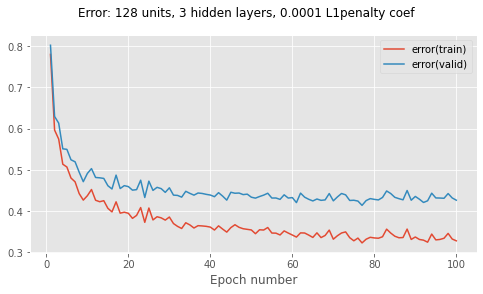

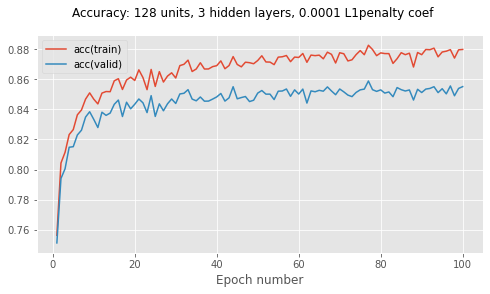

Epoch 1: 8.0s to complete
    error(train)=7.48e-01, acc(train)=7.64e-01, error(valid)=7.74e-01, acc(valid)=7.60e-01


Epoch 2: 8.0s to complete
    error(train)=5.69e-01, acc(train)=8.10e-01, error(valid)=6.15e-01, acc(valid)=7.97e-01


Epoch 3: 8.0s to complete
    error(train)=5.16e-01, acc(train)=8.27e-01, error(valid)=5.69e-01, acc(valid)=8.13e-01


Epoch 4: 7.9s to complete
    error(train)=4.63e-01, acc(train)=8.39e-01, error(valid)=5.17e-01, acc(valid)=8.24e-01


Epoch 5: 8.0s to complete
    error(train)=4.64e-01, acc(train)=8.38e-01, error(valid)=5.25e-01, acc(valid)=8.20e-01


Epoch 6: 8.4s to complete
    error(train)=4.24e-01, acc(train)=8.52e-01, error(valid)=4.92e-01, acc(valid)=8.34e-01


Epoch 7: 8.1s to complete
    error(train)=4.21e-01, acc(train)=8.52e-01, error(valid)=4.89e-01, acc(valid)=8.35e-01


Epoch 8: 7.9s to complete
    error(train)=4.02e-01, acc(train)=8.57e-01, error(valid)=4.83e-01, acc(valid)=8.37e-01


Epoch 9: 8.0s to complete
    error(train)=3.79e-01, acc(train)=8.65e-01, error(valid)=4.54e-01, acc(valid)=8.45e-01


Epoch 10: 8.3s to complete
    error(train)=3.90e-01, acc(train)=8.61e-01, error(valid)=4.75e-01, acc(valid)=8.37e-01


Epoch 11: 8.0s to complete
    error(train)=3.71e-01, acc(train)=8.67e-01, error(valid)=4.59e-01, acc(valid)=8.45e-01


Epoch 12: 8.4s to complete
    error(train)=3.69e-01, acc(train)=8.67e-01, error(valid)=4.59e-01, acc(valid)=8.43e-01


Epoch 13: 8.2s to complete
    error(train)=3.68e-01, acc(train)=8.66e-01, error(valid)=4.60e-01, acc(valid)=8.44e-01


Epoch 14: 8.0s to complete
    error(train)=3.58e-01, acc(train)=8.71e-01, error(valid)=4.50e-01, acc(valid)=8.47e-01


Epoch 15: 8.3s to complete
    error(train)=3.46e-01, acc(train)=8.76e-01, error(valid)=4.40e-01, acc(valid)=8.50e-01


Epoch 16: 7.9s to complete
    error(train)=3.40e-01, acc(train)=8.76e-01, error(valid)=4.36e-01, acc(valid)=8.53e-01


Epoch 17: 7.9s to complete
    error(train)=3.68e-01, acc(train)=8.65e-01, error(valid)=4.69e-01, acc(valid)=8.38e-01


Epoch 18: 8.0s to complete
    error(train)=3.53e-01, acc(train)=8.71e-01, error(valid)=4.62e-01, acc(valid)=8.41e-01


Epoch 19: 8.2s to complete
    error(train)=3.38e-01, acc(train)=8.76e-01, error(valid)=4.48e-01, acc(valid)=8.46e-01


Epoch 20: 8.2s to complete
    error(train)=3.26e-01, acc(train)=8.80e-01, error(valid)=4.38e-01, acc(valid)=8.53e-01


Epoch 21: 8.0s to complete
    error(train)=3.36e-01, acc(train)=8.76e-01, error(valid)=4.50e-01, acc(valid)=8.50e-01


Epoch 22: 8.1s to complete
    error(train)=3.19e-01, acc(train)=8.81e-01, error(valid)=4.35e-01, acc(valid)=8.50e-01


Epoch 23: 8.2s to complete
    error(train)=3.38e-01, acc(train)=8.76e-01, error(valid)=4.53e-01, acc(valid)=8.46e-01


Epoch 24: 8.2s to complete
    error(train)=3.23e-01, acc(train)=8.80e-01, error(valid)=4.29e-01, acc(valid)=8.54e-01


Epoch 25: 8.4s to complete
    error(train)=3.24e-01, acc(train)=8.79e-01, error(valid)=4.42e-01, acc(valid)=8.50e-01


Epoch 26: 7.8s to complete
    error(train)=3.30e-01, acc(train)=8.78e-01, error(valid)=4.48e-01, acc(valid)=8.48e-01


Epoch 27: 8.0s to complete
    error(train)=3.12e-01, acc(train)=8.81e-01, error(valid)=4.35e-01, acc(valid)=8.45e-01


Epoch 28: 8.1s to complete
    error(train)=3.19e-01, acc(train)=8.79e-01, error(valid)=4.46e-01, acc(valid)=8.44e-01


Epoch 29: 8.1s to complete
    error(train)=3.18e-01, acc(train)=8.81e-01, error(valid)=4.38e-01, acc(valid)=8.49e-01


Epoch 30: 8.4s to complete
    error(train)=3.08e-01, acc(train)=8.83e-01, error(valid)=4.38e-01, acc(valid)=8.48e-01


Epoch 31: 8.0s to complete
    error(train)=3.01e-01, acc(train)=8.88e-01, error(valid)=4.28e-01, acc(valid)=8.54e-01


Epoch 32: 8.5s to complete
    error(train)=3.02e-01, acc(train)=8.88e-01, error(valid)=4.30e-01, acc(valid)=8.53e-01


Epoch 33: 8.8s to complete
    error(train)=2.93e-01, acc(train)=8.90e-01, error(valid)=4.25e-01, acc(valid)=8.55e-01


Epoch 34: 9.0s to complete
    error(train)=3.05e-01, acc(train)=8.84e-01, error(valid)=4.36e-01, acc(valid)=8.50e-01


Epoch 35: 9.1s to complete
    error(train)=3.08e-01, acc(train)=8.84e-01, error(valid)=4.45e-01, acc(valid)=8.51e-01


Epoch 36: 8.8s to complete
    error(train)=2.98e-01, acc(train)=8.88e-01, error(valid)=4.38e-01, acc(valid)=8.50e-01


Epoch 37: 9.2s to complete
    error(train)=3.00e-01, acc(train)=8.84e-01, error(valid)=4.43e-01, acc(valid)=8.45e-01


Epoch 38: 8.9s to complete
    error(train)=3.20e-01, acc(train)=8.78e-01, error(valid)=4.67e-01, acc(valid)=8.41e-01


Epoch 39: 7.8s to complete
    error(train)=2.93e-01, acc(train)=8.89e-01, error(valid)=4.32e-01, acc(valid)=8.53e-01


Epoch 40: 7.9s to complete
    error(train)=2.85e-01, acc(train)=8.90e-01, error(valid)=4.28e-01, acc(valid)=8.53e-01


Epoch 41: 8.1s to complete
    error(train)=2.74e-01, acc(train)=8.95e-01, error(valid)=4.15e-01, acc(valid)=8.56e-01


Epoch 42: 8.1s to complete
    error(train)=2.81e-01, acc(train)=8.92e-01, error(valid)=4.32e-01, acc(valid)=8.55e-01


Epoch 43: 8.2s to complete
    error(train)=2.80e-01, acc(train)=8.94e-01, error(valid)=4.25e-01, acc(valid)=8.53e-01


Epoch 44: 8.0s to complete
    error(train)=2.82e-01, acc(train)=8.92e-01, error(valid)=4.34e-01, acc(valid)=8.57e-01


Epoch 45: 8.2s to complete
    error(train)=2.77e-01, acc(train)=8.96e-01, error(valid)=4.19e-01, acc(valid)=8.56e-01


Epoch 46: 8.1s to complete
    error(train)=2.75e-01, acc(train)=8.95e-01, error(valid)=4.31e-01, acc(valid)=8.56e-01


Epoch 47: 8.1s to complete
    error(train)=2.79e-01, acc(train)=8.95e-01, error(valid)=4.33e-01, acc(valid)=8.55e-01


Epoch 48: 8.0s to complete
    error(train)=2.89e-01, acc(train)=8.89e-01, error(valid)=4.36e-01, acc(valid)=8.50e-01


Epoch 49: 8.0s to complete
    error(train)=2.82e-01, acc(train)=8.92e-01, error(valid)=4.40e-01, acc(valid)=8.50e-01


Epoch 50: 8.1s to complete
    error(train)=2.74e-01, acc(train)=8.96e-01, error(valid)=4.26e-01, acc(valid)=8.55e-01


Epoch 51: 8.0s to complete
    error(train)=3.07e-01, acc(train)=8.83e-01, error(valid)=4.70e-01, acc(valid)=8.44e-01


Epoch 52: 8.0s to complete
    error(train)=2.82e-01, acc(train)=8.93e-01, error(valid)=4.34e-01, acc(valid)=8.53e-01


Epoch 53: 8.0s to complete
    error(train)=2.79e-01, acc(train)=8.94e-01, error(valid)=4.35e-01, acc(valid)=8.55e-01


Epoch 54: 8.1s to complete
    error(train)=2.79e-01, acc(train)=8.93e-01, error(valid)=4.47e-01, acc(valid)=8.52e-01


Epoch 55: 8.0s to complete
    error(train)=2.66e-01, acc(train)=8.98e-01, error(valid)=4.30e-01, acc(valid)=8.56e-01


Epoch 56: 8.1s to complete
    error(train)=2.72e-01, acc(train)=8.96e-01, error(valid)=4.40e-01, acc(valid)=8.51e-01


Epoch 57: 8.2s to complete
    error(train)=2.60e-01, acc(train)=9.01e-01, error(valid)=4.21e-01, acc(valid)=8.58e-01


Epoch 58: 8.0s to complete
    error(train)=2.72e-01, acc(train)=8.96e-01, error(valid)=4.39e-01, acc(valid)=8.53e-01


Epoch 59: 8.3s to complete
    error(train)=2.73e-01, acc(train)=8.95e-01, error(valid)=4.37e-01, acc(valid)=8.56e-01


Epoch 60: 8.2s to complete
    error(train)=2.89e-01, acc(train)=8.90e-01, error(valid)=4.60e-01, acc(valid)=8.49e-01


Epoch 61: 8.1s to complete
    error(train)=2.71e-01, acc(train)=8.96e-01, error(valid)=4.38e-01, acc(valid)=8.52e-01


Epoch 62: 8.1s to complete
    error(train)=2.73e-01, acc(train)=8.94e-01, error(valid)=4.47e-01, acc(valid)=8.49e-01


Epoch 63: 8.1s to complete
    error(train)=2.75e-01, acc(train)=8.94e-01, error(valid)=4.43e-01, acc(valid)=8.53e-01


Epoch 64: 8.1s to complete
    error(train)=2.67e-01, acc(train)=8.98e-01, error(valid)=4.43e-01, acc(valid)=8.53e-01


Epoch 65: 8.0s to complete
    error(train)=2.59e-01, acc(train)=8.99e-01, error(valid)=4.30e-01, acc(valid)=8.55e-01


Epoch 66: 7.9s to complete
    error(train)=2.67e-01, acc(train)=8.98e-01, error(valid)=4.42e-01, acc(valid)=8.56e-01


Epoch 67: 8.1s to complete
    error(train)=2.61e-01, acc(train)=8.99e-01, error(valid)=4.39e-01, acc(valid)=8.56e-01


Epoch 68: 8.1s to complete
    error(train)=2.78e-01, acc(train)=8.93e-01, error(valid)=4.53e-01, acc(valid)=8.50e-01


Epoch 69: 7.6s to complete
    error(train)=2.60e-01, acc(train)=8.99e-01, error(valid)=4.43e-01, acc(valid)=8.57e-01


Epoch 70: 8.2s to complete
    error(train)=2.60e-01, acc(train)=8.99e-01, error(valid)=4.44e-01, acc(valid)=8.51e-01


Epoch 71: 8.1s to complete
    error(train)=2.69e-01, acc(train)=8.98e-01, error(valid)=4.56e-01, acc(valid)=8.53e-01


Epoch 72: 8.0s to complete
    error(train)=2.88e-01, acc(train)=8.86e-01, error(valid)=4.70e-01, acc(valid)=8.43e-01


Epoch 73: 8.2s to complete
    error(train)=2.61e-01, acc(train)=8.98e-01, error(valid)=4.49e-01, acc(valid)=8.52e-01


Epoch 74: 8.1s to complete
    error(train)=2.58e-01, acc(train)=9.00e-01, error(valid)=4.36e-01, acc(valid)=8.54e-01


Epoch 75: 7.9s to complete
    error(train)=2.56e-01, acc(train)=9.02e-01, error(valid)=4.42e-01, acc(valid)=8.53e-01


Epoch 76: 8.3s to complete
    error(train)=2.54e-01, acc(train)=9.01e-01, error(valid)=4.41e-01, acc(valid)=8.51e-01


Epoch 77: 8.0s to complete
    error(train)=2.53e-01, acc(train)=9.03e-01, error(valid)=4.34e-01, acc(valid)=8.56e-01


Epoch 78: 8.3s to complete
    error(train)=2.50e-01, acc(train)=9.04e-01, error(valid)=4.40e-01, acc(valid)=8.57e-01


Epoch 79: 8.0s to complete
    error(train)=2.55e-01, acc(train)=9.01e-01, error(valid)=4.50e-01, acc(valid)=8.51e-01


Epoch 80: 8.1s to complete
    error(train)=2.59e-01, acc(train)=8.99e-01, error(valid)=4.61e-01, acc(valid)=8.54e-01


Epoch 81: 8.1s to complete
    error(train)=2.60e-01, acc(train)=8.99e-01, error(valid)=4.51e-01, acc(valid)=8.52e-01


Epoch 82: 8.2s to complete
    error(train)=2.47e-01, acc(train)=9.04e-01, error(valid)=4.50e-01, acc(valid)=8.57e-01


Epoch 83: 8.2s to complete
    error(train)=2.47e-01, acc(train)=9.03e-01, error(valid)=4.42e-01, acc(valid)=8.55e-01


Epoch 84: 8.0s to complete
    error(train)=2.61e-01, acc(train)=8.99e-01, error(valid)=4.52e-01, acc(valid)=8.55e-01


Epoch 85: 8.1s to complete
    error(train)=2.62e-01, acc(train)=8.98e-01, error(valid)=4.60e-01, acc(valid)=8.51e-01


Epoch 86: 8.1s to complete
    error(train)=2.53e-01, acc(train)=9.01e-01, error(valid)=4.44e-01, acc(valid)=8.53e-01


Epoch 87: 8.0s to complete
    error(train)=2.63e-01, acc(train)=8.99e-01, error(valid)=4.61e-01, acc(valid)=8.49e-01


Epoch 88: 8.3s to complete
    error(train)=2.51e-01, acc(train)=9.01e-01, error(valid)=4.53e-01, acc(valid)=8.53e-01


Epoch 89: 8.2s to complete
    error(train)=2.45e-01, acc(train)=9.04e-01, error(valid)=4.50e-01, acc(valid)=8.52e-01


Epoch 90: 8.2s to complete
    error(train)=2.55e-01, acc(train)=9.00e-01, error(valid)=4.53e-01, acc(valid)=8.52e-01


Epoch 91: 8.2s to complete
    error(train)=2.59e-01, acc(train)=9.00e-01, error(valid)=4.62e-01, acc(valid)=8.50e-01


Epoch 92: 8.0s to complete
    error(train)=2.44e-01, acc(train)=9.06e-01, error(valid)=4.37e-01, acc(valid)=8.55e-01


Epoch 93: 8.4s to complete
    error(train)=2.40e-01, acc(train)=9.06e-01, error(valid)=4.51e-01, acc(valid)=8.51e-01


Epoch 94: 8.0s to complete
    error(train)=2.78e-01, acc(train)=8.92e-01, error(valid)=4.72e-01, acc(valid)=8.45e-01


Epoch 95: 8.2s to complete
    error(train)=2.53e-01, acc(train)=9.01e-01, error(valid)=4.64e-01, acc(valid)=8.49e-01


Epoch 96: 8.0s to complete
    error(train)=2.53e-01, acc(train)=9.00e-01, error(valid)=4.49e-01, acc(valid)=8.54e-01


Epoch 97: 8.0s to complete
    error(train)=2.39e-01, acc(train)=9.07e-01, error(valid)=4.44e-01, acc(valid)=8.58e-01


Epoch 98: 8.1s to complete
    error(train)=2.57e-01, acc(train)=9.01e-01, error(valid)=4.57e-01, acc(valid)=8.53e-01


Epoch 99: 8.0s to complete
    error(train)=2.51e-01, acc(train)=9.03e-01, error(valid)=4.59e-01, acc(valid)=8.52e-01


Epoch 100: 8.4s to complete
    error(train)=2.50e-01, acc(train)=9.02e-01, error(valid)=4.66e-01, acc(valid)=8.52e-01


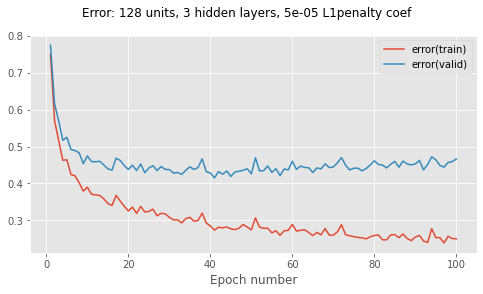

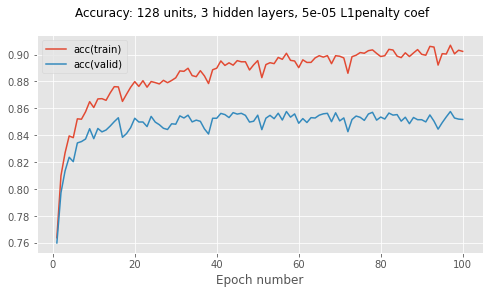

Epoch 1: 8.3s to complete
    error(train)=7.41e-01, acc(train)=7.66e-01, error(valid)=7.68e-01, acc(valid)=7.58e-01


Epoch 2: 7.9s to complete
    error(train)=5.54e-01, acc(train)=8.15e-01, error(valid)=6.09e-01, acc(valid)=7.99e-01


Epoch 3: 7.8s to complete
    error(train)=4.88e-01, acc(train)=8.34e-01, error(valid)=5.55e-01, acc(valid)=8.16e-01


Epoch 4: 8.0s to complete
    error(train)=4.42e-01, acc(train)=8.45e-01, error(valid)=5.16e-01, acc(valid)=8.27e-01


Epoch 5: 8.2s to complete
    error(train)=4.10e-01, acc(train)=8.55e-01, error(valid)=5.02e-01, acc(valid)=8.29e-01


Epoch 6: 8.3s to complete
    error(train)=4.03e-01, acc(train)=8.56e-01, error(valid)=5.06e-01, acc(valid)=8.29e-01


Epoch 7: 8.2s to complete
    error(train)=3.68e-01, acc(train)=8.68e-01, error(valid)=4.86e-01, acc(valid)=8.38e-01


Epoch 8: 8.0s to complete
    error(train)=3.48e-01, acc(train)=8.73e-01, error(valid)=4.81e-01, acc(valid)=8.40e-01


Epoch 9: 8.1s to complete
    error(train)=3.23e-01, acc(train)=8.81e-01, error(valid)=4.67e-01, acc(valid)=8.47e-01


Epoch 10: 8.2s to complete
    error(train)=3.18e-01, acc(train)=8.82e-01, error(valid)=4.71e-01, acc(valid)=8.45e-01


Epoch 11: 8.1s to complete
    error(train)=3.22e-01, acc(train)=8.81e-01, error(valid)=4.88e-01, acc(valid)=8.41e-01


Epoch 12: 8.0s to complete
    error(train)=3.06e-01, acc(train)=8.84e-01, error(valid)=4.77e-01, acc(valid)=8.45e-01


Epoch 13: 8.0s to complete
    error(train)=2.93e-01, acc(train)=8.88e-01, error(valid)=4.71e-01, acc(valid)=8.46e-01


Epoch 14: 8.0s to complete
    error(train)=2.81e-01, acc(train)=8.94e-01, error(valid)=4.70e-01, acc(valid)=8.47e-01


Epoch 15: 8.0s to complete
    error(train)=2.78e-01, acc(train)=8.93e-01, error(valid)=4.82e-01, acc(valid)=8.46e-01


Epoch 16: 8.1s to complete
    error(train)=2.64e-01, acc(train)=8.98e-01, error(valid)=4.70e-01, acc(valid)=8.47e-01


Epoch 17: 8.3s to complete
    error(train)=2.68e-01, acc(train)=8.97e-01, error(valid)=4.94e-01, acc(valid)=8.45e-01


Epoch 18: 7.9s to complete
    error(train)=2.50e-01, acc(train)=9.03e-01, error(valid)=4.81e-01, acc(valid)=8.47e-01


Epoch 19: 7.9s to complete
    error(train)=2.68e-01, acc(train)=8.95e-01, error(valid)=5.07e-01, acc(valid)=8.40e-01


Epoch 20: 8.3s to complete
    error(train)=2.58e-01, acc(train)=8.98e-01, error(valid)=5.24e-01, acc(valid)=8.41e-01


Epoch 21: 8.3s to complete
    error(train)=2.48e-01, acc(train)=9.03e-01, error(valid)=5.27e-01, acc(valid)=8.44e-01


Epoch 22: 8.0s to complete
    error(train)=2.35e-01, acc(train)=9.07e-01, error(valid)=5.12e-01, acc(valid)=8.44e-01


Epoch 23: 8.0s to complete
    error(train)=2.52e-01, acc(train)=9.01e-01, error(valid)=5.37e-01, acc(valid)=8.42e-01


Epoch 24: 8.1s to complete
    error(train)=2.39e-01, acc(train)=9.04e-01, error(valid)=5.31e-01, acc(valid)=8.40e-01


Epoch 25: 8.4s to complete
    error(train)=2.20e-01, acc(train)=9.11e-01, error(valid)=5.19e-01, acc(valid)=8.46e-01


Epoch 26: 7.9s to complete
    error(train)=2.29e-01, acc(train)=9.09e-01, error(valid)=5.45e-01, acc(valid)=8.42e-01


Epoch 27: 8.1s to complete
    error(train)=2.27e-01, acc(train)=9.08e-01, error(valid)=5.67e-01, acc(valid)=8.39e-01


Epoch 28: 8.2s to complete
    error(train)=2.24e-01, acc(train)=9.09e-01, error(valid)=5.76e-01, acc(valid)=8.39e-01


Epoch 29: 7.9s to complete
    error(train)=2.17e-01, acc(train)=9.13e-01, error(valid)=5.60e-01, acc(valid)=8.42e-01


Epoch 30: 8.3s to complete
    error(train)=2.06e-01, acc(train)=9.16e-01, error(valid)=5.58e-01, acc(valid)=8.42e-01


Epoch 31: 8.0s to complete
    error(train)=2.05e-01, acc(train)=9.17e-01, error(valid)=5.66e-01, acc(valid)=8.44e-01


Epoch 32: 8.8s to complete
    error(train)=2.03e-01, acc(train)=9.17e-01, error(valid)=5.58e-01, acc(valid)=8.43e-01


Epoch 33: 8.5s to complete
    error(train)=1.98e-01, acc(train)=9.19e-01, error(valid)=5.72e-01, acc(valid)=8.47e-01


Epoch 34: 9.0s to complete
    error(train)=1.98e-01, acc(train)=9.18e-01, error(valid)=5.89e-01, acc(valid)=8.43e-01


Epoch 35: 9.0s to complete
    error(train)=1.95e-01, acc(train)=9.20e-01, error(valid)=5.77e-01, acc(valid)=8.44e-01


Epoch 36: 9.2s to complete
    error(train)=1.87e-01, acc(train)=9.24e-01, error(valid)=5.79e-01, acc(valid)=8.43e-01


Epoch 37: 9.2s to complete
    error(train)=1.94e-01, acc(train)=9.21e-01, error(valid)=6.05e-01, acc(valid)=8.41e-01


Epoch 38: 8.5s to complete
    error(train)=1.74e-01, acc(train)=9.28e-01, error(valid)=5.94e-01, acc(valid)=8.46e-01


Epoch 39: 8.1s to complete
    error(train)=1.92e-01, acc(train)=9.21e-01, error(valid)=6.36e-01, acc(valid)=8.39e-01


Epoch 40: 8.0s to complete
    error(train)=1.78e-01, acc(train)=9.26e-01, error(valid)=5.99e-01, acc(valid)=8.44e-01


Epoch 41: 8.1s to complete
    error(train)=1.79e-01, acc(train)=9.26e-01, error(valid)=6.14e-01, acc(valid)=8.42e-01


Epoch 42: 8.0s to complete
    error(train)=1.80e-01, acc(train)=9.26e-01, error(valid)=6.27e-01, acc(valid)=8.42e-01


Epoch 43: 8.1s to complete
    error(train)=1.66e-01, acc(train)=9.31e-01, error(valid)=6.18e-01, acc(valid)=8.46e-01


Epoch 44: 8.0s to complete
    error(train)=1.84e-01, acc(train)=9.25e-01, error(valid)=6.40e-01, acc(valid)=8.41e-01


Epoch 45: 7.9s to complete
    error(train)=1.80e-01, acc(train)=9.25e-01, error(valid)=6.46e-01, acc(valid)=8.39e-01


Epoch 46: 8.2s to complete
    error(train)=1.77e-01, acc(train)=9.27e-01, error(valid)=6.50e-01, acc(valid)=8.40e-01


Epoch 47: 7.7s to complete
    error(train)=1.64e-01, acc(train)=9.33e-01, error(valid)=6.48e-01, acc(valid)=8.43e-01


Epoch 48: 8.1s to complete
    error(train)=1.73e-01, acc(train)=9.28e-01, error(valid)=6.65e-01, acc(valid)=8.42e-01


Epoch 49: 8.1s to complete
    error(train)=1.73e-01, acc(train)=9.29e-01, error(valid)=6.63e-01, acc(valid)=8.42e-01


Epoch 50: 7.9s to complete
    error(train)=1.82e-01, acc(train)=9.26e-01, error(valid)=6.88e-01, acc(valid)=8.36e-01


Epoch 51: 8.0s to complete
    error(train)=1.70e-01, acc(train)=9.30e-01, error(valid)=6.76e-01, acc(valid)=8.39e-01


Epoch 52: 8.1s to complete
    error(train)=1.69e-01, acc(train)=9.31e-01, error(valid)=6.57e-01, acc(valid)=8.43e-01


Epoch 53: 8.0s to complete
    error(train)=1.71e-01, acc(train)=9.31e-01, error(valid)=6.88e-01, acc(valid)=8.40e-01


Epoch 54: 8.0s to complete
    error(train)=1.80e-01, acc(train)=9.26e-01, error(valid)=7.13e-01, acc(valid)=8.35e-01


Epoch 55: 8.0s to complete
    error(train)=1.64e-01, acc(train)=9.33e-01, error(valid)=6.94e-01, acc(valid)=8.39e-01


Epoch 56: 8.2s to complete
    error(train)=1.68e-01, acc(train)=9.32e-01, error(valid)=7.32e-01, acc(valid)=8.36e-01


Epoch 57: 8.1s to complete
    error(train)=1.69e-01, acc(train)=9.30e-01, error(valid)=6.88e-01, acc(valid)=8.39e-01


Epoch 58: 8.2s to complete
    error(train)=1.75e-01, acc(train)=9.28e-01, error(valid)=7.41e-01, acc(valid)=8.33e-01


Epoch 59: 8.0s to complete
    error(train)=1.60e-01, acc(train)=9.34e-01, error(valid)=7.05e-01, acc(valid)=8.40e-01


Epoch 60: 8.1s to complete
    error(train)=1.52e-01, acc(train)=9.37e-01, error(valid)=7.15e-01, acc(valid)=8.40e-01


Epoch 61: 8.2s to complete
    error(train)=1.68e-01, acc(train)=9.32e-01, error(valid)=7.15e-01, acc(valid)=8.40e-01


Epoch 62: 8.0s to complete
    error(train)=1.55e-01, acc(train)=9.36e-01, error(valid)=7.29e-01, acc(valid)=8.35e-01


Epoch 63: 7.9s to complete
    error(train)=1.51e-01, acc(train)=9.37e-01, error(valid)=7.38e-01, acc(valid)=8.38e-01


Epoch 64: 8.2s to complete
    error(train)=1.45e-01, acc(train)=9.40e-01, error(valid)=7.33e-01, acc(valid)=8.41e-01


Epoch 65: 8.0s to complete
    error(train)=1.42e-01, acc(train)=9.41e-01, error(valid)=7.34e-01, acc(valid)=8.38e-01


Epoch 66: 7.9s to complete
    error(train)=1.53e-01, acc(train)=9.38e-01, error(valid)=7.59e-01, acc(valid)=8.37e-01


Epoch 67: 8.0s to complete
    error(train)=1.46e-01, acc(train)=9.41e-01, error(valid)=7.49e-01, acc(valid)=8.41e-01


Epoch 68: 8.0s to complete
    error(train)=1.54e-01, acc(train)=9.37e-01, error(valid)=7.61e-01, acc(valid)=8.37e-01


Epoch 69: 8.2s to complete
    error(train)=1.54e-01, acc(train)=9.37e-01, error(valid)=7.79e-01, acc(valid)=8.34e-01


Epoch 70: 7.9s to complete
    error(train)=1.39e-01, acc(train)=9.42e-01, error(valid)=7.51e-01, acc(valid)=8.41e-01


Epoch 71: 8.0s to complete
    error(train)=1.49e-01, acc(train)=9.39e-01, error(valid)=7.72e-01, acc(valid)=8.38e-01


Epoch 72: 8.2s to complete
    error(train)=1.45e-01, acc(train)=9.39e-01, error(valid)=7.77e-01, acc(valid)=8.37e-01


Epoch 73: 7.9s to complete
    error(train)=1.52e-01, acc(train)=9.37e-01, error(valid)=8.12e-01, acc(valid)=8.32e-01


Epoch 74: 7.7s to complete
    error(train)=1.56e-01, acc(train)=9.36e-01, error(valid)=7.82e-01, acc(valid)=8.36e-01


Epoch 75: 8.0s to complete
    error(train)=1.54e-01, acc(train)=9.36e-01, error(valid)=7.76e-01, acc(valid)=8.36e-01


Epoch 76: 8.0s to complete
    error(train)=1.46e-01, acc(train)=9.40e-01, error(valid)=7.85e-01, acc(valid)=8.37e-01


Epoch 77: 8.1s to complete
    error(train)=1.40e-01, acc(train)=9.42e-01, error(valid)=7.81e-01, acc(valid)=8.35e-01


Epoch 78: 8.0s to complete
    error(train)=1.40e-01, acc(train)=9.43e-01, error(valid)=7.89e-01, acc(valid)=8.39e-01


Epoch 79: 8.0s to complete
    error(train)=1.38e-01, acc(train)=9.45e-01, error(valid)=8.09e-01, acc(valid)=8.37e-01


Epoch 80: 7.8s to complete
    error(train)=1.36e-01, acc(train)=9.45e-01, error(valid)=7.84e-01, acc(valid)=8.37e-01


Epoch 81: 8.1s to complete
    error(train)=1.40e-01, acc(train)=9.43e-01, error(valid)=8.05e-01, acc(valid)=8.37e-01


Epoch 82: 8.1s to complete
    error(train)=1.33e-01, acc(train)=9.46e-01, error(valid)=8.05e-01, acc(valid)=8.35e-01


Epoch 83: 8.4s to complete
    error(train)=1.58e-01, acc(train)=9.36e-01, error(valid)=8.37e-01, acc(valid)=8.32e-01


Epoch 84: 7.7s to complete
    error(train)=1.29e-01, acc(train)=9.47e-01, error(valid)=8.25e-01, acc(valid)=8.36e-01


Epoch 85: 7.9s to complete
    error(train)=1.50e-01, acc(train)=9.40e-01, error(valid)=8.68e-01, acc(valid)=8.33e-01


Epoch 86: 8.1s to complete
    error(train)=1.49e-01, acc(train)=9.39e-01, error(valid)=8.66e-01, acc(valid)=8.35e-01


Epoch 87: 8.0s to complete
    error(train)=1.46e-01, acc(train)=9.42e-01, error(valid)=8.42e-01, acc(valid)=8.34e-01


Epoch 88: 8.0s to complete
    error(train)=1.27e-01, acc(train)=9.48e-01, error(valid)=8.39e-01, acc(valid)=8.36e-01


Epoch 89: 7.9s to complete
    error(train)=1.45e-01, acc(train)=9.41e-01, error(valid)=8.39e-01, acc(valid)=8.36e-01


Epoch 90: 7.9s to complete
    error(train)=1.36e-01, acc(train)=9.44e-01, error(valid)=8.26e-01, acc(valid)=8.38e-01


Epoch 91: 8.0s to complete
    error(train)=1.30e-01, acc(train)=9.46e-01, error(valid)=8.35e-01, acc(valid)=8.32e-01


Epoch 92: 8.0s to complete
    error(train)=1.39e-01, acc(train)=9.44e-01, error(valid)=8.34e-01, acc(valid)=8.33e-01


Epoch 93: 8.0s to complete
    error(train)=1.32e-01, acc(train)=9.46e-01, error(valid)=8.59e-01, acc(valid)=8.36e-01


Epoch 94: 7.7s to complete
    error(train)=1.31e-01, acc(train)=9.47e-01, error(valid)=8.35e-01, acc(valid)=8.39e-01


Epoch 95: 8.0s to complete
    error(train)=1.22e-01, acc(train)=9.50e-01, error(valid)=8.19e-01, acc(valid)=8.40e-01


Epoch 96: 7.9s to complete
    error(train)=1.36e-01, acc(train)=9.46e-01, error(valid)=8.44e-01, acc(valid)=8.32e-01


Epoch 97: 7.9s to complete
    error(train)=1.31e-01, acc(train)=9.48e-01, error(valid)=8.60e-01, acc(valid)=8.36e-01


Epoch 98: 8.0s to complete
    error(train)=1.30e-01, acc(train)=9.47e-01, error(valid)=8.56e-01, acc(valid)=8.35e-01


Epoch 99: 7.9s to complete
    error(train)=1.38e-01, acc(train)=9.45e-01, error(valid)=8.74e-01, acc(valid)=8.32e-01


Epoch 100: 8.3s to complete
    error(train)=1.25e-01, acc(train)=9.49e-01, error(valid)=8.85e-01, acc(valid)=8.35e-01


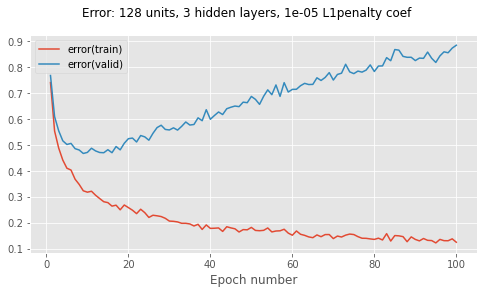

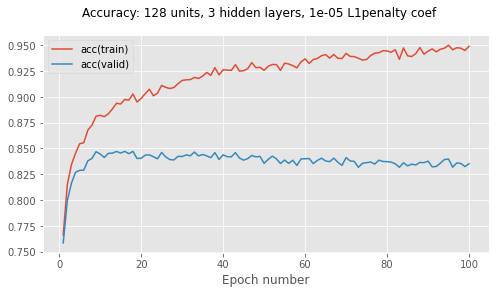

save successfully
save successfully
save successfully


In [40]:
# 128 ReLU hidden units
# 100 epoch
# AdamLearningRule default learning rate: 1e-03
# L1Penalty coefficients [0.0001, 0.0001/2, 0.00001]

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser
from mlp.penalties import L1Penalty

#setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
L1Penalty_coefficients = [0.0001, 0.0001/2, 0.00001]

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []
L1_all_stats = []

for L1Penalty_coefficient in L1Penalty_coefficients:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
                AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient)),  # input layer
                ReluLayer(),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient)), # hidden layer 1
                ReluLayer(),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient)), # hidden layer 2
                ReluLayer(),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient)), # hidden layer 3
                ReluLayer(),
                AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient))])# output layer


    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    #Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook = True)
    
    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])
    L1_all_stats.append(stats)

    # Add figure title
    fig_1.suptitle('Error: 128 units, 3 hidden layers, {} L1penalty coef'.format(L1Penalty_coefficient))
    fig_2.suptitle('Accuracy: 128 units, 3 hidden layers, {} L1penalty coef'.format(L1Penalty_coefficient))
    # Save figure as Pdf
    #fig_1.savefig('plots/L1_{0:.0e}(Err).pdf'.format(L1Penalty_coefficient))
    #fig_2.savefig('plots/L1_{0:.0e}(Acc).pdf'.format(L1Penalty_coefficient))

    plt.show()

# save data
j = 0
for L1Penalty_coefficient in L1Penalty_coefficients:
    results = {'Number of ReLU hidden units':hidden_dim,
               'Number of epochs':num_epochs,
               'Defualt learning_rate': 1e-3,
               'L1Penalty coef':L1Penalty_coefficient,
               'final error(train)':final_errors_train[j],
               'final error(valid)':final_errors_valid[j],
               'final acc(train)':final_accs_train[j],
               'final acc(valid)':final_accs_valid[j]
              }
    save_data(results,'stats/L1Penalty_{}.npy'.format(L1Penalty_coefficient))
    j += 1

In [41]:
save_data(L1_all_stats,'stats/L1.npy')

save successfully


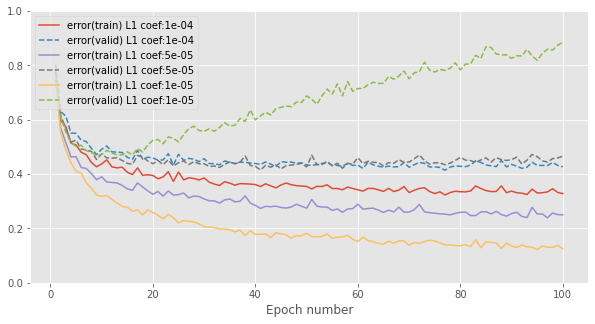

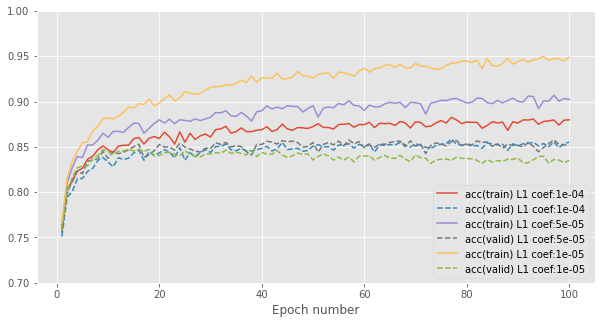

In [29]:
linestyle = ['-','--']

fig_3 = plt.figure(figsize=(10, 5))
ax_3 = fig_3.add_subplot(111)
ax_3.set_ylim([0.0,1.0])
j = 0
for stats in all_stats:
    i = 0
    for k in ['error(train)', 'error(valid)']:
        label = k + ' L1 coef:{0:.0e}'.format(L1Penalty_coefficients[j])
        ax_3.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=label,
                 ls = linestyle[i])
        i += 1
    j += 1
ax_3.legend(loc=0)
ax_3.set_xlabel('Epoch number')

fig_4 = plt.figure(figsize=(10, 5))
ax_4 = fig_4.add_subplot(111)
ax_4.set_ylim([0.7,1.0])
j = 0
for stats in all_stats:
    i = 0    
    for k in ['acc(train)', 'acc(valid)']:
        label = k + ' L1 coef:{0:.0e}'.format(L1Penalty_coefficients[j])
        ax_4.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=label,
                ls = linestyle[i])
        i += 1
    j += 1
ax_4.legend(loc=0)
ax_4.set_xlabel('Epoch number')

fig_3.savefig('plots/L1(Err).pdf')
fig_4.savefig('plots/L1(Acc).pdf')

Epoch 1: 5.5s to complete
    error(train)=7.75e-01, acc(train)=7.59e-01, error(valid)=8.00e-01, acc(valid)=7.56e-01


Epoch 2: 5.6s to complete
    error(train)=5.93e-01, acc(train)=8.05e-01, error(valid)=6.30e-01, acc(valid)=7.94e-01


Epoch 3: 6.0s to complete
    error(train)=5.39e-01, acc(train)=8.21e-01, error(valid)=5.83e-01, acc(valid)=8.11e-01


Epoch 4: 5.7s to complete
    error(train)=4.91e-01, acc(train)=8.34e-01, error(valid)=5.34e-01, acc(valid)=8.20e-01


Epoch 5: 5.7s to complete
    error(train)=4.99e-01, acc(train)=8.30e-01, error(valid)=5.48e-01, acc(valid)=8.17e-01


Epoch 6: 5.7s to complete
    error(train)=4.67e-01, acc(train)=8.41e-01, error(valid)=5.19e-01, acc(valid)=8.25e-01


Epoch 7: 6.0s to complete
    error(train)=4.55e-01, acc(train)=8.46e-01, error(valid)=5.09e-01, acc(valid)=8.31e-01


Epoch 8: 5.9s to complete
    error(train)=4.35e-01, acc(train)=8.51e-01, error(valid)=4.92e-01, acc(valid)=8.36e-01


Epoch 9: 6.0s to complete
    error(train)=4.22e-01, acc(train)=8.53e-01, error(valid)=4.79e-01, acc(valid)=8.34e-01


Epoch 10: 5.8s to complete
    error(train)=4.31e-01, acc(train)=8.51e-01, error(valid)=4.94e-01, acc(valid)=8.36e-01


Epoch 11: 5.8s to complete
    error(train)=4.34e-01, acc(train)=8.50e-01, error(valid)=4.96e-01, acc(valid)=8.33e-01


Epoch 12: 5.8s to complete
    error(train)=4.14e-01, acc(train)=8.55e-01, error(valid)=4.75e-01, acc(valid)=8.37e-01


Epoch 13: 5.5s to complete
    error(train)=4.10e-01, acc(train)=8.56e-01, error(valid)=4.74e-01, acc(valid)=8.38e-01


Epoch 14: 6.5s to complete
    error(train)=4.02e-01, acc(train)=8.62e-01, error(valid)=4.62e-01, acc(valid)=8.44e-01


Epoch 15: 7.8s to complete
    error(train)=4.08e-01, acc(train)=8.59e-01, error(valid)=4.70e-01, acc(valid)=8.40e-01


Epoch 16: 8.9s to complete
    error(train)=3.97e-01, acc(train)=8.61e-01, error(valid)=4.60e-01, acc(valid)=8.43e-01


Epoch 17: 8.4s to complete
    error(train)=4.16e-01, acc(train)=8.55e-01, error(valid)=4.79e-01, acc(valid)=8.39e-01


Epoch 18: 8.1s to complete
    error(train)=3.90e-01, acc(train)=8.63e-01, error(valid)=4.61e-01, acc(valid)=8.46e-01


Epoch 19: 7.4s to complete
    error(train)=3.90e-01, acc(train)=8.63e-01, error(valid)=4.56e-01, acc(valid)=8.41e-01


Epoch 20: 7.3s to complete
    error(train)=3.99e-01, acc(train)=8.59e-01, error(valid)=4.68e-01, acc(valid)=8.38e-01


Epoch 21: 6.7s to complete
    error(train)=3.92e-01, acc(train)=8.64e-01, error(valid)=4.67e-01, acc(valid)=8.43e-01


Epoch 22: 6.3s to complete
    error(train)=3.80e-01, acc(train)=8.64e-01, error(valid)=4.48e-01, acc(valid)=8.46e-01


Epoch 23: 6.2s to complete
    error(train)=3.93e-01, acc(train)=8.61e-01, error(valid)=4.62e-01, acc(valid)=8.41e-01


Epoch 24: 6.0s to complete
    error(train)=3.80e-01, acc(train)=8.66e-01, error(valid)=4.41e-01, acc(valid)=8.49e-01


Epoch 25: 5.9s to complete
    error(train)=3.71e-01, acc(train)=8.70e-01, error(valid)=4.35e-01, acc(valid)=8.50e-01


Epoch 26: 6.1s to complete
    error(train)=3.78e-01, acc(train)=8.68e-01, error(valid)=4.49e-01, acc(valid)=8.46e-01


Epoch 27: 6.1s to complete
    error(train)=3.81e-01, acc(train)=8.61e-01, error(valid)=4.49e-01, acc(valid)=8.41e-01


Epoch 28: 6.2s to complete
    error(train)=3.88e-01, acc(train)=8.61e-01, error(valid)=4.59e-01, acc(valid)=8.39e-01


Epoch 29: 6.1s to complete
    error(train)=3.82e-01, acc(train)=8.64e-01, error(valid)=4.50e-01, acc(valid)=8.46e-01


Epoch 30: 5.9s to complete
    error(train)=3.78e-01, acc(train)=8.64e-01, error(valid)=4.47e-01, acc(valid)=8.46e-01


Epoch 31: 6.3s to complete
    error(train)=3.84e-01, acc(train)=8.64e-01, error(valid)=4.52e-01, acc(valid)=8.45e-01


Epoch 32: 7.0s to complete
    error(train)=3.73e-01, acc(train)=8.68e-01, error(valid)=4.50e-01, acc(valid)=8.46e-01


Epoch 33: 7.1s to complete
    error(train)=3.69e-01, acc(train)=8.70e-01, error(valid)=4.43e-01, acc(valid)=8.50e-01


Epoch 34: 7.4s to complete
    error(train)=3.79e-01, acc(train)=8.65e-01, error(valid)=4.54e-01, acc(valid)=8.45e-01


Epoch 35: 7.3s to complete
    error(train)=3.91e-01, acc(train)=8.59e-01, error(valid)=4.63e-01, acc(valid)=8.40e-01


Epoch 36: 7.8s to complete
    error(train)=3.54e-01, acc(train)=8.75e-01, error(valid)=4.26e-01, acc(valid)=8.52e-01


Epoch 37: 8.3s to complete
    error(train)=3.87e-01, acc(train)=8.62e-01, error(valid)=4.65e-01, acc(valid)=8.37e-01


Epoch 38: 7.3s to complete
    error(train)=3.88e-01, acc(train)=8.60e-01, error(valid)=4.63e-01, acc(valid)=8.38e-01


Epoch 39: 6.9s to complete
    error(train)=3.68e-01, acc(train)=8.68e-01, error(valid)=4.40e-01, acc(valid)=8.49e-01


Epoch 40: 7.4s to complete
    error(train)=3.61e-01, acc(train)=8.71e-01, error(valid)=4.37e-01, acc(valid)=8.52e-01


Epoch 41: 7.7s to complete
    error(train)=3.50e-01, acc(train)=8.75e-01, error(valid)=4.26e-01, acc(valid)=8.52e-01


Epoch 42: 7.7s to complete
    error(train)=3.60e-01, acc(train)=8.71e-01, error(valid)=4.35e-01, acc(valid)=8.51e-01


Epoch 43: 7.5s to complete
    error(train)=3.66e-01, acc(train)=8.70e-01, error(valid)=4.42e-01, acc(valid)=8.47e-01


Epoch 44: 7.5s to complete
    error(train)=3.48e-01, acc(train)=8.77e-01, error(valid)=4.15e-01, acc(valid)=8.58e-01


Epoch 45: 7.5s to complete
    error(train)=3.65e-01, acc(train)=8.71e-01, error(valid)=4.39e-01, acc(valid)=8.48e-01


Epoch 46: 7.5s to complete
    error(train)=3.78e-01, acc(train)=8.67e-01, error(valid)=4.53e-01, acc(valid)=8.44e-01


Epoch 47: 7.0s to complete
    error(train)=3.53e-01, acc(train)=8.76e-01, error(valid)=4.28e-01, acc(valid)=8.57e-01


Epoch 48: 7.0s to complete
    error(train)=3.58e-01, acc(train)=8.75e-01, error(valid)=4.32e-01, acc(valid)=8.53e-01


Epoch 49: 7.1s to complete
    error(train)=3.59e-01, acc(train)=8.71e-01, error(valid)=4.33e-01, acc(valid)=8.49e-01


Epoch 50: 6.9s to complete
    error(train)=3.81e-01, acc(train)=8.66e-01, error(valid)=4.55e-01, acc(valid)=8.43e-01


Epoch 51: 6.9s to complete
    error(train)=3.52e-01, acc(train)=8.75e-01, error(valid)=4.25e-01, acc(valid)=8.54e-01


Epoch 52: 7.1s to complete
    error(train)=3.66e-01, acc(train)=8.71e-01, error(valid)=4.41e-01, acc(valid)=8.49e-01


Epoch 53: 7.6s to complete
    error(train)=3.55e-01, acc(train)=8.72e-01, error(valid)=4.28e-01, acc(valid)=8.52e-01


Epoch 54: 7.4s to complete
    error(train)=3.54e-01, acc(train)=8.75e-01, error(valid)=4.28e-01, acc(valid)=8.52e-01


Epoch 55: 7.2s to complete
    error(train)=3.53e-01, acc(train)=8.74e-01, error(valid)=4.25e-01, acc(valid)=8.53e-01


Epoch 56: 7.3s to complete
    error(train)=3.65e-01, acc(train)=8.73e-01, error(valid)=4.42e-01, acc(valid)=8.49e-01


Epoch 57: 7.0s to complete
    error(train)=3.63e-01, acc(train)=8.71e-01, error(valid)=4.38e-01, acc(valid)=8.49e-01


Epoch 58: 6.8s to complete
    error(train)=3.48e-01, acc(train)=8.77e-01, error(valid)=4.19e-01, acc(valid)=8.56e-01


Epoch 59: 7.1s to complete
    error(train)=3.67e-01, acc(train)=8.71e-01, error(valid)=4.39e-01, acc(valid)=8.50e-01


Epoch 60: 7.0s to complete
    error(train)=3.57e-01, acc(train)=8.73e-01, error(valid)=4.37e-01, acc(valid)=8.50e-01


Epoch 61: 7.4s to complete
    error(train)=3.55e-01, acc(train)=8.74e-01, error(valid)=4.31e-01, acc(valid)=8.51e-01


Epoch 62: 6.8s to complete
    error(train)=3.64e-01, acc(train)=8.69e-01, error(valid)=4.44e-01, acc(valid)=8.45e-01


Epoch 63: 6.7s to complete
    error(train)=3.55e-01, acc(train)=8.75e-01, error(valid)=4.30e-01, acc(valid)=8.54e-01


Epoch 64: 6.7s to complete
    error(train)=3.56e-01, acc(train)=8.72e-01, error(valid)=4.34e-01, acc(valid)=8.52e-01


Epoch 65: 6.8s to complete
    error(train)=3.64e-01, acc(train)=8.70e-01, error(valid)=4.42e-01, acc(valid)=8.46e-01


Epoch 66: 7.0s to complete
    error(train)=3.57e-01, acc(train)=8.73e-01, error(valid)=4.34e-01, acc(valid)=8.47e-01


Epoch 67: 7.0s to complete
    error(train)=3.48e-01, acc(train)=8.76e-01, error(valid)=4.24e-01, acc(valid)=8.54e-01


Epoch 68: 7.2s to complete
    error(train)=3.51e-01, acc(train)=8.75e-01, error(valid)=4.25e-01, acc(valid)=8.54e-01


Epoch 69: 7.4s to complete
    error(train)=3.58e-01, acc(train)=8.72e-01, error(valid)=4.34e-01, acc(valid)=8.53e-01


Epoch 70: 7.8s to complete
    error(train)=3.46e-01, acc(train)=8.75e-01, error(valid)=4.24e-01, acc(valid)=8.54e-01


Epoch 71: 7.8s to complete
    error(train)=3.43e-01, acc(train)=8.78e-01, error(valid)=4.21e-01, acc(valid)=8.55e-01


Epoch 72: 8.1s to complete
    error(train)=3.57e-01, acc(train)=8.72e-01, error(valid)=4.31e-01, acc(valid)=8.49e-01


Epoch 73: 8.0s to complete
    error(train)=3.50e-01, acc(train)=8.76e-01, error(valid)=4.26e-01, acc(valid)=8.53e-01


Epoch 74: 7.7s to complete
    error(train)=3.53e-01, acc(train)=8.74e-01, error(valid)=4.24e-01, acc(valid)=8.53e-01


Epoch 75: 7.9s to complete
    error(train)=3.45e-01, acc(train)=8.77e-01, error(valid)=4.24e-01, acc(valid)=8.52e-01


Epoch 76: 7.5s to complete
    error(train)=3.49e-01, acc(train)=8.76e-01, error(valid)=4.20e-01, acc(valid)=8.54e-01


Epoch 77: 7.5s to complete
    error(train)=3.51e-01, acc(train)=8.77e-01, error(valid)=4.22e-01, acc(valid)=8.57e-01


Epoch 78: 7.2s to complete
    error(train)=3.43e-01, acc(train)=8.79e-01, error(valid)=4.19e-01, acc(valid)=8.55e-01


Epoch 79: 7.1s to complete
    error(train)=3.45e-01, acc(train)=8.77e-01, error(valid)=4.21e-01, acc(valid)=8.55e-01


Epoch 80: 6.9s to complete
    error(train)=3.44e-01, acc(train)=8.77e-01, error(valid)=4.14e-01, acc(valid)=8.56e-01


Epoch 81: 6.6s to complete
    error(train)=3.44e-01, acc(train)=8.76e-01, error(valid)=4.23e-01, acc(valid)=8.52e-01


Epoch 82: 6.8s to complete
    error(train)=3.44e-01, acc(train)=8.78e-01, error(valid)=4.17e-01, acc(valid)=8.57e-01


Epoch 83: 7.2s to complete
    error(train)=3.41e-01, acc(train)=8.78e-01, error(valid)=4.23e-01, acc(valid)=8.56e-01


Epoch 84: 7.4s to complete
    error(train)=3.44e-01, acc(train)=8.78e-01, error(valid)=4.22e-01, acc(valid)=8.55e-01


Epoch 85: 7.7s to complete
    error(train)=3.45e-01, acc(train)=8.76e-01, error(valid)=4.21e-01, acc(valid)=8.52e-01


Epoch 86: 7.5s to complete
    error(train)=3.61e-01, acc(train)=8.72e-01, error(valid)=4.35e-01, acc(valid)=8.51e-01


Epoch 87: 7.5s to complete
    error(train)=3.46e-01, acc(train)=8.77e-01, error(valid)=4.18e-01, acc(valid)=8.55e-01


Epoch 88: 7.4s to complete
    error(train)=3.54e-01, acc(train)=8.73e-01, error(valid)=4.33e-01, acc(valid)=8.50e-01


Epoch 89: 7.4s to complete
    error(train)=3.47e-01, acc(train)=8.76e-01, error(valid)=4.24e-01, acc(valid)=8.51e-01


Epoch 90: 7.2s to complete
    error(train)=3.56e-01, acc(train)=8.73e-01, error(valid)=4.37e-01, acc(valid)=8.52e-01


Epoch 91: 7.1s to complete
    error(train)=3.62e-01, acc(train)=8.72e-01, error(valid)=4.47e-01, acc(valid)=8.47e-01


Epoch 92: 7.1s to complete
    error(train)=3.48e-01, acc(train)=8.76e-01, error(valid)=4.22e-01, acc(valid)=8.56e-01


Epoch 93: 7.2s to complete
    error(train)=3.47e-01, acc(train)=8.75e-01, error(valid)=4.27e-01, acc(valid)=8.52e-01


Epoch 94: 7.2s to complete
    error(train)=3.56e-01, acc(train)=8.74e-01, error(valid)=4.30e-01, acc(valid)=8.54e-01


Epoch 95: 7.3s to complete
    error(train)=3.42e-01, acc(train)=8.80e-01, error(valid)=4.21e-01, acc(valid)=8.54e-01


Epoch 96: 7.6s to complete
    error(train)=3.50e-01, acc(train)=8.76e-01, error(valid)=4.25e-01, acc(valid)=8.52e-01


Epoch 97: 7.7s to complete
    error(train)=3.47e-01, acc(train)=8.78e-01, error(valid)=4.23e-01, acc(valid)=8.56e-01


Epoch 98: 7.3s to complete
    error(train)=3.56e-01, acc(train)=8.75e-01, error(valid)=4.36e-01, acc(valid)=8.52e-01


Epoch 99: 7.2s to complete
    error(train)=3.65e-01, acc(train)=8.71e-01, error(valid)=4.43e-01, acc(valid)=8.47e-01


Epoch 100: 7.0s to complete
    error(train)=3.52e-01, acc(train)=8.76e-01, error(valid)=4.23e-01, acc(valid)=8.56e-01


Epoch 1: 5.6s to complete
    error(train)=7.33e-01, acc(train)=7.69e-01, error(valid)=7.60e-01, acc(valid)=7.63e-01


Epoch 2: 5.7s to complete
    error(train)=5.62e-01, acc(train)=8.15e-01, error(valid)=6.08e-01, acc(valid)=8.03e-01


Epoch 3: 5.8s to complete
    error(train)=5.11e-01, acc(train)=8.29e-01, error(valid)=5.62e-01, acc(valid)=8.13e-01


Epoch 4: 5.6s to complete
    error(train)=4.57e-01, acc(train)=8.43e-01, error(valid)=5.12e-01, acc(valid)=8.26e-01


Epoch 5: 5.8s to complete
    error(train)=4.50e-01, acc(train)=8.43e-01, error(valid)=5.13e-01, acc(valid)=8.26e-01


Epoch 6: 5.7s to complete
    error(train)=4.29e-01, acc(train)=8.50e-01, error(valid)=4.99e-01, acc(valid)=8.31e-01


Epoch 7: 6.2s to complete
    error(train)=4.18e-01, acc(train)=8.54e-01, error(valid)=4.98e-01, acc(valid)=8.31e-01


Epoch 8: 5.8s to complete
    error(train)=4.00e-01, acc(train)=8.59e-01, error(valid)=4.81e-01, acc(valid)=8.37e-01


Epoch 9: 5.7s to complete
    error(train)=3.72e-01, acc(train)=8.66e-01, error(valid)=4.54e-01, acc(valid)=8.43e-01


Epoch 10: 5.8s to complete
    error(train)=3.73e-01, acc(train)=8.68e-01, error(valid)=4.58e-01, acc(valid)=8.46e-01


Epoch 11: 5.8s to complete
    error(train)=3.89e-01, acc(train)=8.63e-01, error(valid)=4.75e-01, acc(valid)=8.39e-01


Epoch 12: 5.8s to complete
    error(train)=3.64e-01, acc(train)=8.68e-01, error(valid)=4.58e-01, acc(valid)=8.43e-01


Epoch 13: 5.8s to complete
    error(train)=3.71e-01, acc(train)=8.65e-01, error(valid)=4.63e-01, acc(valid)=8.42e-01


Epoch 14: 7.5s to complete
    error(train)=3.64e-01, acc(train)=8.70e-01, error(valid)=4.62e-01, acc(valid)=8.44e-01


Epoch 15: 8.2s to complete
    error(train)=3.63e-01, acc(train)=8.71e-01, error(valid)=4.57e-01, acc(valid)=8.46e-01


Epoch 16: 8.2s to complete
    error(train)=3.42e-01, acc(train)=8.76e-01, error(valid)=4.41e-01, acc(valid)=8.49e-01


Epoch 17: 8.1s to complete
    error(train)=3.48e-01, acc(train)=8.76e-01, error(valid)=4.49e-01, acc(valid)=8.49e-01


Epoch 18: 8.4s to complete
    error(train)=3.46e-01, acc(train)=8.74e-01, error(valid)=4.48e-01, acc(valid)=8.47e-01


Epoch 19: 8.3s to complete
    error(train)=3.42e-01, acc(train)=8.76e-01, error(valid)=4.48e-01, acc(valid)=8.47e-01


Epoch 20: 8.5s to complete
    error(train)=3.54e-01, acc(train)=8.69e-01, error(valid)=4.62e-01, acc(valid)=8.41e-01


Epoch 21: 8.6s to complete
    error(train)=3.36e-01, acc(train)=8.79e-01, error(valid)=4.46e-01, acc(valid)=8.49e-01


Epoch 22: 8.1s to complete
    error(train)=3.15e-01, acc(train)=8.83e-01, error(valid)=4.26e-01, acc(valid)=8.51e-01


Epoch 23: 7.7s to complete
    error(train)=3.54e-01, acc(train)=8.70e-01, error(valid)=4.71e-01, acc(valid)=8.40e-01


Epoch 24: 7.2s to complete
    error(train)=3.28e-01, acc(train)=8.79e-01, error(valid)=4.36e-01, acc(valid)=8.51e-01


Epoch 25: 6.6s to complete
    error(train)=3.28e-01, acc(train)=8.80e-01, error(valid)=4.40e-01, acc(valid)=8.48e-01


Epoch 26: 6.3s to complete
    error(train)=3.23e-01, acc(train)=8.83e-01, error(valid)=4.38e-01, acc(valid)=8.50e-01


Epoch 27: 6.5s to complete
    error(train)=3.09e-01, acc(train)=8.83e-01, error(valid)=4.23e-01, acc(valid)=8.52e-01


Epoch 28: 6.1s to complete
    error(train)=3.17e-01, acc(train)=8.82e-01, error(valid)=4.34e-01, acc(valid)=8.47e-01


Epoch 29: 6.1s to complete
    error(train)=3.12e-01, acc(train)=8.84e-01, error(valid)=4.31e-01, acc(valid)=8.52e-01


Epoch 30: 6.4s to complete
    error(train)=3.12e-01, acc(train)=8.83e-01, error(valid)=4.31e-01, acc(valid)=8.50e-01


Epoch 31: 6.3s to complete
    error(train)=3.11e-01, acc(train)=8.85e-01, error(valid)=4.30e-01, acc(valid)=8.52e-01


Epoch 32: 6.5s to complete
    error(train)=2.95e-01, acc(train)=8.90e-01, error(valid)=4.13e-01, acc(valid)=8.59e-01


Epoch 33: 6.7s to complete
    error(train)=3.12e-01, acc(train)=8.84e-01, error(valid)=4.32e-01, acc(valid)=8.50e-01


Epoch 34: 7.2s to complete
    error(train)=3.05e-01, acc(train)=8.85e-01, error(valid)=4.29e-01, acc(valid)=8.51e-01


Epoch 35: 6.7s to complete
    error(train)=3.13e-01, acc(train)=8.83e-01, error(valid)=4.37e-01, acc(valid)=8.48e-01


Epoch 36: 7.1s to complete
    error(train)=2.95e-01, acc(train)=8.91e-01, error(valid)=4.19e-01, acc(valid)=8.56e-01


Epoch 37: 7.3s to complete
    error(train)=3.04e-01, acc(train)=8.87e-01, error(valid)=4.27e-01, acc(valid)=8.52e-01


Epoch 38: 6.6s to complete
    error(train)=3.08e-01, acc(train)=8.85e-01, error(valid)=4.35e-01, acc(valid)=8.51e-01


Epoch 39: 6.1s to complete
    error(train)=3.03e-01, acc(train)=8.87e-01, error(valid)=4.26e-01, acc(valid)=8.53e-01


Epoch 40: 6.2s to complete
    error(train)=2.96e-01, acc(train)=8.90e-01, error(valid)=4.23e-01, acc(valid)=8.57e-01


Epoch 41: 6.0s to complete
    error(train)=2.85e-01, acc(train)=8.94e-01, error(valid)=4.09e-01, acc(valid)=8.59e-01


Epoch 42: 6.0s to complete
    error(train)=2.97e-01, acc(train)=8.88e-01, error(valid)=4.26e-01, acc(valid)=8.52e-01


Epoch 43: 6.0s to complete
    error(train)=3.06e-01, acc(train)=8.87e-01, error(valid)=4.42e-01, acc(valid)=8.47e-01


Epoch 44: 6.2s to complete
    error(train)=2.89e-01, acc(train)=8.93e-01, error(valid)=4.19e-01, acc(valid)=8.56e-01


Epoch 45: 6.2s to complete
    error(train)=3.11e-01, acc(train)=8.86e-01, error(valid)=4.39e-01, acc(valid)=8.51e-01


Epoch 46: 6.4s to complete
    error(train)=2.90e-01, acc(train)=8.92e-01, error(valid)=4.25e-01, acc(valid)=8.54e-01


Epoch 47: 6.4s to complete
    error(train)=2.88e-01, acc(train)=8.94e-01, error(valid)=4.23e-01, acc(valid)=8.56e-01


Epoch 48: 6.2s to complete
    error(train)=3.10e-01, acc(train)=8.87e-01, error(valid)=4.45e-01, acc(valid)=8.50e-01


Epoch 49: 6.6s to complete
    error(train)=2.88e-01, acc(train)=8.94e-01, error(valid)=4.22e-01, acc(valid)=8.53e-01


Epoch 50: 6.4s to complete
    error(train)=3.04e-01, acc(train)=8.87e-01, error(valid)=4.39e-01, acc(valid)=8.50e-01


Epoch 51: 6.9s to complete
    error(train)=2.94e-01, acc(train)=8.89e-01, error(valid)=4.31e-01, acc(valid)=8.54e-01


Epoch 52: 7.0s to complete
    error(train)=2.90e-01, acc(train)=8.93e-01, error(valid)=4.23e-01, acc(valid)=8.55e-01


Epoch 53: 6.9s to complete
    error(train)=2.82e-01, acc(train)=8.95e-01, error(valid)=4.16e-01, acc(valid)=8.58e-01


Epoch 54: 7.0s to complete
    error(train)=2.81e-01, acc(train)=8.94e-01, error(valid)=4.18e-01, acc(valid)=8.56e-01


Epoch 55: 7.0s to complete
    error(train)=2.74e-01, acc(train)=8.97e-01, error(valid)=4.07e-01, acc(valid)=8.62e-01


Epoch 56: 7.0s to complete
    error(train)=2.89e-01, acc(train)=8.92e-01, error(valid)=4.28e-01, acc(valid)=8.52e-01


Epoch 57: 6.6s to complete
    error(train)=2.80e-01, acc(train)=8.95e-01, error(valid)=4.16e-01, acc(valid)=8.54e-01


Epoch 58: 6.9s to complete
    error(train)=2.88e-01, acc(train)=8.94e-01, error(valid)=4.18e-01, acc(valid)=8.57e-01


Epoch 59: 6.8s to complete
    error(train)=2.90e-01, acc(train)=8.92e-01, error(valid)=4.25e-01, acc(valid)=8.56e-01


Epoch 60: 6.9s to complete
    error(train)=2.95e-01, acc(train)=8.90e-01, error(valid)=4.34e-01, acc(valid)=8.53e-01


Epoch 61: 6.9s to complete
    error(train)=3.02e-01, acc(train)=8.89e-01, error(valid)=4.39e-01, acc(valid)=8.51e-01


Epoch 62: 7.4s to complete
    error(train)=2.83e-01, acc(train)=8.93e-01, error(valid)=4.29e-01, acc(valid)=8.51e-01


Epoch 63: 7.3s to complete
    error(train)=2.85e-01, acc(train)=8.95e-01, error(valid)=4.21e-01, acc(valid)=8.56e-01


Epoch 64: 7.2s to complete
    error(train)=2.85e-01, acc(train)=8.94e-01, error(valid)=4.23e-01, acc(valid)=8.53e-01


Epoch 65: 6.8s to complete
    error(train)=2.87e-01, acc(train)=8.92e-01, error(valid)=4.31e-01, acc(valid)=8.51e-01


Epoch 66: 6.9s to complete
    error(train)=2.80e-01, acc(train)=8.95e-01, error(valid)=4.16e-01, acc(valid)=8.56e-01


Epoch 67: 7.0s to complete
    error(train)=2.82e-01, acc(train)=8.94e-01, error(valid)=4.18e-01, acc(valid)=8.55e-01


Epoch 68: 6.5s to complete
    error(train)=2.80e-01, acc(train)=8.96e-01, error(valid)=4.16e-01, acc(valid)=8.57e-01


Epoch 69: 6.9s to complete
    error(train)=2.86e-01, acc(train)=8.93e-01, error(valid)=4.26e-01, acc(valid)=8.57e-01


Epoch 70: 7.0s to complete
    error(train)=2.83e-01, acc(train)=8.93e-01, error(valid)=4.25e-01, acc(valid)=8.56e-01


Epoch 71: 7.3s to complete
    error(train)=2.74e-01, acc(train)=8.97e-01, error(valid)=4.14e-01, acc(valid)=8.57e-01


Epoch 72: 7.2s to complete
    error(train)=2.96e-01, acc(train)=8.87e-01, error(valid)=4.40e-01, acc(valid)=8.48e-01


Epoch 73: 6.9s to complete
    error(train)=2.76e-01, acc(train)=8.96e-01, error(valid)=4.16e-01, acc(valid)=8.58e-01


Epoch 74: 6.4s to complete
    error(train)=2.99e-01, acc(train)=8.89e-01, error(valid)=4.39e-01, acc(valid)=8.50e-01


Epoch 75: 6.6s to complete
    error(train)=2.81e-01, acc(train)=8.94e-01, error(valid)=4.25e-01, acc(valid)=8.53e-01


Epoch 76: 6.5s to complete
    error(train)=2.87e-01, acc(train)=8.92e-01, error(valid)=4.26e-01, acc(valid)=8.54e-01


Epoch 77: 7.1s to complete
    error(train)=2.76e-01, acc(train)=8.97e-01, error(valid)=4.20e-01, acc(valid)=8.55e-01


Epoch 78: 7.2s to complete
    error(train)=2.76e-01, acc(train)=8.97e-01, error(valid)=4.14e-01, acc(valid)=8.58e-01


Epoch 79: 7.3s to complete
    error(train)=2.90e-01, acc(train)=8.91e-01, error(valid)=4.31e-01, acc(valid)=8.53e-01


Epoch 80: 7.4s to complete
    error(train)=2.77e-01, acc(train)=8.96e-01, error(valid)=4.16e-01, acc(valid)=8.55e-01


Epoch 81: 7.2s to complete
    error(train)=2.74e-01, acc(train)=8.98e-01, error(valid)=4.20e-01, acc(valid)=8.56e-01


Epoch 82: 6.9s to complete
    error(train)=2.86e-01, acc(train)=8.92e-01, error(valid)=4.35e-01, acc(valid)=8.53e-01


Epoch 83: 6.7s to complete
    error(train)=2.70e-01, acc(train)=9.00e-01, error(valid)=4.18e-01, acc(valid)=8.59e-01


Epoch 84: 6.9s to complete
    error(train)=2.94e-01, acc(train)=8.91e-01, error(valid)=4.37e-01, acc(valid)=8.52e-01


Epoch 85: 6.7s to complete
    error(train)=2.82e-01, acc(train)=8.94e-01, error(valid)=4.28e-01, acc(valid)=8.53e-01


Epoch 86: 6.7s to complete
    error(train)=2.82e-01, acc(train)=8.95e-01, error(valid)=4.23e-01, acc(valid)=8.55e-01


Epoch 87: 6.7s to complete
    error(train)=2.77e-01, acc(train)=8.95e-01, error(valid)=4.20e-01, acc(valid)=8.56e-01


Epoch 88: 6.6s to complete
    error(train)=2.92e-01, acc(train)=8.90e-01, error(valid)=4.37e-01, acc(valid)=8.51e-01


Epoch 89: 6.6s to complete
    error(train)=2.70e-01, acc(train)=8.98e-01, error(valid)=4.18e-01, acc(valid)=8.55e-01


Epoch 90: 6.8s to complete
    error(train)=2.84e-01, acc(train)=8.93e-01, error(valid)=4.31e-01, acc(valid)=8.55e-01


Epoch 91: 6.7s to complete
    error(train)=2.75e-01, acc(train)=8.98e-01, error(valid)=4.24e-01, acc(valid)=8.56e-01


Epoch 92: 6.6s to complete
    error(train)=2.70e-01, acc(train)=8.99e-01, error(valid)=4.07e-01, acc(valid)=8.60e-01


Epoch 93: 6.8s to complete
    error(train)=2.77e-01, acc(train)=8.93e-01, error(valid)=4.23e-01, acc(valid)=8.52e-01


Epoch 94: 6.8s to complete
    error(train)=2.78e-01, acc(train)=8.98e-01, error(valid)=4.12e-01, acc(valid)=8.63e-01


Epoch 95: 6.6s to complete
    error(train)=2.72e-01, acc(train)=8.98e-01, error(valid)=4.16e-01, acc(valid)=8.59e-01


Epoch 96: 6.7s to complete
    error(train)=2.75e-01, acc(train)=8.97e-01, error(valid)=4.17e-01, acc(valid)=8.58e-01


Epoch 97: 6.6s to complete
    error(train)=2.76e-01, acc(train)=8.97e-01, error(valid)=4.20e-01, acc(valid)=8.58e-01


Epoch 98: 7.1s to complete
    error(train)=2.74e-01, acc(train)=8.98e-01, error(valid)=4.18e-01, acc(valid)=8.55e-01


Epoch 99: 7.3s to complete
    error(train)=2.82e-01, acc(train)=8.95e-01, error(valid)=4.31e-01, acc(valid)=8.54e-01


Epoch 100: 7.6s to complete
    error(train)=2.78e-01, acc(train)=8.95e-01, error(valid)=4.24e-01, acc(valid)=8.54e-01


Epoch 1: 5.5s to complete
    error(train)=7.29e-01, acc(train)=7.70e-01, error(valid)=7.57e-01, acc(valid)=7.63e-01


Epoch 2: 5.6s to complete
    error(train)=5.61e-01, acc(train)=8.14e-01, error(valid)=6.17e-01, acc(valid)=8.01e-01


Epoch 3: 5.8s to complete
    error(train)=4.88e-01, acc(train)=8.35e-01, error(valid)=5.54e-01, acc(valid)=8.20e-01


Epoch 4: 5.8s to complete
    error(train)=4.57e-01, acc(train)=8.39e-01, error(valid)=5.30e-01, acc(valid)=8.18e-01


Epoch 5: 5.6s to complete
    error(train)=4.18e-01, acc(train)=8.52e-01, error(valid)=5.11e-01, acc(valid)=8.27e-01


Epoch 6: 5.7s to complete
    error(train)=4.00e-01, acc(train)=8.59e-01, error(valid)=5.03e-01, acc(valid)=8.34e-01


Epoch 7: 6.1s to complete
    error(train)=3.71e-01, acc(train)=8.67e-01, error(valid)=4.89e-01, acc(valid)=8.40e-01


Epoch 8: 5.7s to complete
    error(train)=3.47e-01, acc(train)=8.75e-01, error(valid)=4.75e-01, acc(valid)=8.44e-01


Epoch 9: 5.8s to complete
    error(train)=3.37e-01, acc(train)=8.77e-01, error(valid)=4.71e-01, acc(valid)=8.44e-01


Epoch 10: 5.8s to complete
    error(train)=3.36e-01, acc(train)=8.77e-01, error(valid)=4.85e-01, acc(valid)=8.40e-01


Epoch 11: 5.9s to complete
    error(train)=3.20e-01, acc(train)=8.82e-01, error(valid)=4.78e-01, acc(valid)=8.41e-01


Epoch 12: 5.9s to complete
    error(train)=3.06e-01, acc(train)=8.85e-01, error(valid)=4.68e-01, acc(valid)=8.43e-01


Epoch 13: 5.8s to complete
    error(train)=3.06e-01, acc(train)=8.82e-01, error(valid)=4.84e-01, acc(valid)=8.39e-01


Epoch 14: 8.7s to complete
    error(train)=2.96e-01, acc(train)=8.88e-01, error(valid)=4.76e-01, acc(valid)=8.47e-01


Epoch 15: 9.3s to complete
    error(train)=2.84e-01, acc(train)=8.93e-01, error(valid)=4.70e-01, acc(valid)=8.45e-01


Epoch 16: 9.4s to complete
    error(train)=2.77e-01, acc(train)=8.95e-01, error(valid)=4.82e-01, acc(valid)=8.48e-01


Epoch 17: 9.8s to complete
    error(train)=2.75e-01, acc(train)=8.94e-01, error(valid)=4.84e-01, acc(valid)=8.45e-01


Epoch 18: 10.3s to complete
    error(train)=2.64e-01, acc(train)=8.98e-01, error(valid)=4.89e-01, acc(valid)=8.46e-01


Epoch 19: 10.5s to complete
    error(train)=2.65e-01, acc(train)=8.98e-01, error(valid)=4.88e-01, acc(valid)=8.45e-01


Epoch 20: 10.9s to complete
    error(train)=2.58e-01, acc(train)=9.00e-01, error(valid)=5.01e-01, acc(valid)=8.45e-01


Epoch 21: 11.5s to complete
    error(train)=2.49e-01, acc(train)=9.04e-01, error(valid)=4.98e-01, acc(valid)=8.46e-01


Epoch 22: 12.0s to complete
    error(train)=2.38e-01, acc(train)=9.06e-01, error(valid)=4.89e-01, acc(valid)=8.43e-01


Epoch 23: 12.7s to complete
    error(train)=2.62e-01, acc(train)=8.98e-01, error(valid)=5.25e-01, acc(valid)=8.39e-01


Epoch 24: 12.8s to complete
    error(train)=2.43e-01, acc(train)=9.03e-01, error(valid)=5.11e-01, acc(valid)=8.39e-01


Epoch 25: 12.9s to complete
    error(train)=2.46e-01, acc(train)=9.03e-01, error(valid)=5.12e-01, acc(valid)=8.41e-01


Epoch 26: 12.9s to complete
    error(train)=2.34e-01, acc(train)=9.08e-01, error(valid)=5.08e-01, acc(valid)=8.46e-01


Epoch 27: 13.1s to complete
    error(train)=2.23e-01, acc(train)=9.11e-01, error(valid)=5.05e-01, acc(valid)=8.45e-01


Epoch 28: 13.3s to complete
    error(train)=2.24e-01, acc(train)=9.10e-01, error(valid)=5.27e-01, acc(valid)=8.41e-01


Epoch 29: 13.1s to complete
    error(train)=2.15e-01, acc(train)=9.13e-01, error(valid)=5.11e-01, acc(valid)=8.47e-01


Epoch 30: 13.1s to complete
    error(train)=2.17e-01, acc(train)=9.14e-01, error(valid)=5.19e-01, acc(valid)=8.40e-01


Epoch 31: 13.3s to complete
    error(train)=2.16e-01, acc(train)=9.14e-01, error(valid)=5.30e-01, acc(valid)=8.42e-01


Epoch 32: 13.3s to complete
    error(train)=2.19e-01, acc(train)=9.12e-01, error(valid)=5.34e-01, acc(valid)=8.42e-01


Epoch 33: 13.9s to complete
    error(train)=2.13e-01, acc(train)=9.13e-01, error(valid)=5.40e-01, acc(valid)=8.44e-01


Epoch 34: 13.9s to complete
    error(train)=2.03e-01, acc(train)=9.16e-01, error(valid)=5.19e-01, acc(valid)=8.44e-01


Epoch 35: 13.8s to complete
    error(train)=2.05e-01, acc(train)=9.16e-01, error(valid)=5.38e-01, acc(valid)=8.42e-01


Epoch 36: 13.7s to complete
    error(train)=2.06e-01, acc(train)=9.16e-01, error(valid)=5.32e-01, acc(valid)=8.45e-01


Epoch 37: 14.0s to complete
    error(train)=2.07e-01, acc(train)=9.14e-01, error(valid)=5.58e-01, acc(valid)=8.37e-01


Epoch 38: 13.8s to complete
    error(train)=2.03e-01, acc(train)=9.18e-01, error(valid)=5.62e-01, acc(valid)=8.41e-01


Epoch 39: 13.0s to complete
    error(train)=2.10e-01, acc(train)=9.16e-01, error(valid)=5.62e-01, acc(valid)=8.40e-01


Epoch 40: 13.0s to complete
    error(train)=2.01e-01, acc(train)=9.18e-01, error(valid)=5.51e-01, acc(valid)=8.39e-01


Epoch 41: 13.1s to complete
    error(train)=2.00e-01, acc(train)=9.18e-01, error(valid)=5.48e-01, acc(valid)=8.41e-01


Epoch 42: 12.9s to complete
    error(train)=1.99e-01, acc(train)=9.19e-01, error(valid)=5.72e-01, acc(valid)=8.38e-01


Epoch 43: 13.1s to complete
    error(train)=2.07e-01, acc(train)=9.17e-01, error(valid)=5.77e-01, acc(valid)=8.38e-01


Epoch 44: 12.8s to complete
    error(train)=1.86e-01, acc(train)=9.25e-01, error(valid)=5.72e-01, acc(valid)=8.44e-01


Epoch 45: 13.0s to complete
    error(train)=1.88e-01, acc(train)=9.25e-01, error(valid)=5.65e-01, acc(valid)=8.47e-01


Epoch 46: 13.0s to complete
    error(train)=1.81e-01, acc(train)=9.27e-01, error(valid)=5.59e-01, acc(valid)=8.44e-01


Epoch 47: 13.2s to complete
    error(train)=1.84e-01, acc(train)=9.25e-01, error(valid)=5.76e-01, acc(valid)=8.43e-01


Epoch 48: 12.9s to complete
    error(train)=1.88e-01, acc(train)=9.23e-01, error(valid)=5.86e-01, acc(valid)=8.42e-01


Epoch 49: 12.8s to complete
    error(train)=1.79e-01, acc(train)=9.28e-01, error(valid)=5.77e-01, acc(valid)=8.41e-01


Epoch 50: 13.0s to complete
    error(train)=1.94e-01, acc(train)=9.22e-01, error(valid)=5.81e-01, acc(valid)=8.40e-01


Epoch 51: 12.9s to complete
    error(train)=1.89e-01, acc(train)=9.23e-01, error(valid)=5.90e-01, acc(valid)=8.40e-01


Epoch 52: 13.1s to complete
    error(train)=1.75e-01, acc(train)=9.29e-01, error(valid)=5.70e-01, acc(valid)=8.41e-01


Epoch 53: 13.0s to complete
    error(train)=1.73e-01, acc(train)=9.30e-01, error(valid)=5.93e-01, acc(valid)=8.44e-01


Epoch 54: 13.6s to complete
    error(train)=1.87e-01, acc(train)=9.25e-01, error(valid)=6.00e-01, acc(valid)=8.36e-01


Epoch 55: 12.9s to complete
    error(train)=1.71e-01, acc(train)=9.31e-01, error(valid)=5.82e-01, acc(valid)=8.45e-01


Epoch 56: 12.9s to complete
    error(train)=1.69e-01, acc(train)=9.32e-01, error(valid)=5.98e-01, acc(valid)=8.38e-01


Epoch 57: 13.2s to complete
    error(train)=1.90e-01, acc(train)=9.23e-01, error(valid)=6.05e-01, acc(valid)=8.36e-01


Epoch 58: 12.9s to complete
    error(train)=1.76e-01, acc(train)=9.29e-01, error(valid)=6.01e-01, acc(valid)=8.39e-01


Epoch 59: 12.8s to complete
    error(train)=1.64e-01, acc(train)=9.33e-01, error(valid)=6.07e-01, acc(valid)=8.42e-01


Epoch 60: 13.0s to complete
    error(train)=1.87e-01, acc(train)=9.24e-01, error(valid)=6.27e-01, acc(valid)=8.37e-01


Epoch 61: 13.0s to complete
    error(train)=1.64e-01, acc(train)=9.34e-01, error(valid)=6.09e-01, acc(valid)=8.38e-01


Epoch 62: 12.9s to complete
    error(train)=1.79e-01, acc(train)=9.26e-01, error(valid)=6.15e-01, acc(valid)=8.33e-01


Epoch 63: 13.2s to complete
    error(train)=1.65e-01, acc(train)=9.33e-01, error(valid)=6.17e-01, acc(valid)=8.40e-01


Epoch 64: 13.0s to complete
    error(train)=1.60e-01, acc(train)=9.35e-01, error(valid)=6.03e-01, acc(valid)=8.42e-01


Epoch 65: 12.7s to complete
    error(train)=1.66e-01, acc(train)=9.31e-01, error(valid)=6.22e-01, acc(valid)=8.42e-01


Epoch 66: 12.9s to complete
    error(train)=1.66e-01, acc(train)=9.33e-01, error(valid)=6.07e-01, acc(valid)=8.36e-01


Epoch 67: 12.9s to complete
    error(train)=1.69e-01, acc(train)=9.31e-01, error(valid)=6.42e-01, acc(valid)=8.39e-01


Epoch 68: 12.7s to complete
    error(train)=1.68e-01, acc(train)=9.31e-01, error(valid)=6.26e-01, acc(valid)=8.39e-01


Epoch 69: 12.7s to complete
    error(train)=1.62e-01, acc(train)=9.34e-01, error(valid)=6.05e-01, acc(valid)=8.38e-01


Epoch 70: 13.3s to complete
    error(train)=1.70e-01, acc(train)=9.31e-01, error(valid)=6.28e-01, acc(valid)=8.38e-01


Epoch 71: 13.0s to complete
    error(train)=1.58e-01, acc(train)=9.36e-01, error(valid)=6.27e-01, acc(valid)=8.38e-01


Epoch 72: 12.9s to complete
    error(train)=1.70e-01, acc(train)=9.31e-01, error(valid)=6.38e-01, acc(valid)=8.38e-01


Epoch 73: 12.9s to complete
    error(train)=1.63e-01, acc(train)=9.34e-01, error(valid)=6.24e-01, acc(valid)=8.38e-01


Epoch 74: 13.0s to complete
    error(train)=1.75e-01, acc(train)=9.30e-01, error(valid)=6.40e-01, acc(valid)=8.42e-01


Epoch 75: 12.8s to complete
    error(train)=1.62e-01, acc(train)=9.34e-01, error(valid)=6.32e-01, acc(valid)=8.41e-01


Epoch 76: 12.8s to complete
    error(train)=1.59e-01, acc(train)=9.35e-01, error(valid)=6.42e-01, acc(valid)=8.38e-01


Epoch 77: 12.9s to complete
    error(train)=1.72e-01, acc(train)=9.31e-01, error(valid)=6.51e-01, acc(valid)=8.36e-01


Epoch 78: 12.9s to complete
    error(train)=1.61e-01, acc(train)=9.35e-01, error(valid)=6.46e-01, acc(valid)=8.39e-01


Epoch 79: 12.9s to complete
    error(train)=1.51e-01, acc(train)=9.38e-01, error(valid)=6.29e-01, acc(valid)=8.42e-01


Epoch 80: 12.7s to complete
    error(train)=1.72e-01, acc(train)=9.30e-01, error(valid)=6.64e-01, acc(valid)=8.36e-01


Epoch 81: 12.9s to complete
    error(train)=1.47e-01, acc(train)=9.41e-01, error(valid)=6.14e-01, acc(valid)=8.40e-01


Epoch 82: 12.6s to complete
    error(train)=1.47e-01, acc(train)=9.40e-01, error(valid)=6.31e-01, acc(valid)=8.44e-01


Epoch 83: 13.0s to complete
    error(train)=1.54e-01, acc(train)=9.39e-01, error(valid)=6.52e-01, acc(valid)=8.40e-01


Epoch 84: 13.1s to complete
    error(train)=1.48e-01, acc(train)=9.39e-01, error(valid)=6.34e-01, acc(valid)=8.43e-01


Epoch 85: 12.6s to complete
    error(train)=1.48e-01, acc(train)=9.41e-01, error(valid)=6.57e-01, acc(valid)=8.39e-01


Epoch 86: 13.0s to complete
    error(train)=1.72e-01, acc(train)=9.30e-01, error(valid)=6.80e-01, acc(valid)=8.34e-01


Epoch 87: 12.9s to complete
    error(train)=1.48e-01, acc(train)=9.41e-01, error(valid)=6.53e-01, acc(valid)=8.39e-01


Epoch 88: 12.8s to complete
    error(train)=1.59e-01, acc(train)=9.36e-01, error(valid)=6.70e-01, acc(valid)=8.37e-01


Epoch 89: 12.8s to complete
    error(train)=1.47e-01, acc(train)=9.41e-01, error(valid)=6.45e-01, acc(valid)=8.44e-01


Epoch 90: 12.9s to complete
    error(train)=1.50e-01, acc(train)=9.39e-01, error(valid)=6.43e-01, acc(valid)=8.38e-01


Epoch 91: 12.6s to complete
    error(train)=1.64e-01, acc(train)=9.36e-01, error(valid)=6.81e-01, acc(valid)=8.31e-01


Epoch 92: 12.7s to complete
    error(train)=1.43e-01, acc(train)=9.43e-01, error(valid)=6.47e-01, acc(valid)=8.40e-01


Epoch 93: 12.9s to complete
    error(train)=1.46e-01, acc(train)=9.42e-01, error(valid)=6.54e-01, acc(valid)=8.37e-01


Epoch 94: 13.3s to complete
    error(train)=1.47e-01, acc(train)=9.41e-01, error(valid)=6.52e-01, acc(valid)=8.39e-01


Epoch 95: 13.2s to complete
    error(train)=1.56e-01, acc(train)=9.37e-01, error(valid)=6.67e-01, acc(valid)=8.38e-01


Epoch 96: 13.1s to complete
    error(train)=1.42e-01, acc(train)=9.42e-01, error(valid)=6.33e-01, acc(valid)=8.39e-01


Epoch 97: 13.4s to complete
    error(train)=1.33e-01, acc(train)=9.48e-01, error(valid)=6.30e-01, acc(valid)=8.42e-01


Epoch 98: 13.1s to complete
    error(train)=1.47e-01, acc(train)=9.41e-01, error(valid)=6.64e-01, acc(valid)=8.36e-01


Epoch 99: 13.1s to complete
    error(train)=1.48e-01, acc(train)=9.41e-01, error(valid)=6.77e-01, acc(valid)=8.40e-01


Epoch 100: 13.0s to complete
    error(train)=1.53e-01, acc(train)=9.38e-01, error(valid)=6.76e-01, acc(valid)=8.40e-01


Epoch 1: 5.6s to complete
    error(train)=7.25e-01, acc(train)=7.72e-01, error(valid)=7.51e-01, acc(valid)=7.67e-01


Epoch 2: 5.8s to complete
    error(train)=5.48e-01, acc(train)=8.17e-01, error(valid)=6.01e-01, acc(valid)=8.01e-01


Epoch 3: 5.9s to complete
    error(train)=4.73e-01, acc(train)=8.40e-01, error(valid)=5.41e-01, acc(valid)=8.22e-01


Epoch 4: 5.8s to complete
    error(train)=4.30e-01, acc(train)=8.51e-01, error(valid)=5.12e-01, acc(valid)=8.27e-01


Epoch 5: 5.6s to complete
    error(train)=4.09e-01, acc(train)=8.57e-01, error(valid)=5.06e-01, acc(valid)=8.30e-01


Epoch 6: 5.8s to complete
    error(train)=3.86e-01, acc(train)=8.63e-01, error(valid)=4.99e-01, acc(valid)=8.32e-01


Epoch 7: 6.3s to complete
    error(train)=3.68e-01, acc(train)=8.68e-01, error(valid)=4.94e-01, acc(valid)=8.38e-01


Epoch 8: 5.9s to complete
    error(train)=3.40e-01, acc(train)=8.76e-01, error(valid)=4.80e-01, acc(valid)=8.40e-01


Epoch 9: 5.9s to complete
    error(train)=3.36e-01, acc(train)=8.76e-01, error(valid)=4.87e-01, acc(valid)=8.39e-01


Epoch 10: 5.6s to complete
    error(train)=3.06e-01, acc(train)=8.86e-01, error(valid)=4.69e-01, acc(valid)=8.47e-01


Epoch 11: 5.8s to complete
    error(train)=3.05e-01, acc(train)=8.86e-01, error(valid)=4.80e-01, acc(valid)=8.42e-01


Epoch 12: 6.0s to complete
    error(train)=3.00e-01, acc(train)=8.85e-01, error(valid)=4.88e-01, acc(valid)=8.41e-01


Epoch 13: 5.7s to complete
    error(train)=2.97e-01, acc(train)=8.85e-01, error(valid)=4.95e-01, acc(valid)=8.37e-01


Epoch 14: 8.8s to complete
    error(train)=2.72e-01, acc(train)=8.96e-01, error(valid)=4.82e-01, acc(valid)=8.48e-01


Epoch 15: 9.2s to complete
    error(train)=2.75e-01, acc(train)=8.96e-01, error(valid)=4.90e-01, acc(valid)=8.43e-01


Epoch 16: 8.9s to complete
    error(train)=2.68e-01, acc(train)=8.96e-01, error(valid)=4.99e-01, acc(valid)=8.44e-01


Epoch 17: 9.1s to complete
    error(train)=2.65e-01, acc(train)=8.97e-01, error(valid)=5.06e-01, acc(valid)=8.41e-01


Epoch 18: 9.1s to complete
    error(train)=2.47e-01, acc(train)=9.04e-01, error(valid)=5.03e-01, acc(valid)=8.46e-01


Epoch 19: 9.6s to complete
    error(train)=2.36e-01, acc(train)=9.08e-01, error(valid)=5.07e-01, acc(valid)=8.47e-01


Epoch 20: 10.3s to complete
    error(train)=2.40e-01, acc(train)=9.06e-01, error(valid)=5.23e-01, acc(valid)=8.45e-01


Epoch 21: 10.8s to complete
    error(train)=2.36e-01, acc(train)=9.07e-01, error(valid)=5.33e-01, acc(valid)=8.43e-01


Epoch 22: 11.2s to complete
    error(train)=2.40e-01, acc(train)=9.04e-01, error(valid)=5.38e-01, acc(valid)=8.39e-01


Epoch 23: 11.4s to complete
    error(train)=2.41e-01, acc(train)=9.06e-01, error(valid)=5.58e-01, acc(valid)=8.44e-01


Epoch 24: 11.8s to complete
    error(train)=2.24e-01, acc(train)=9.10e-01, error(valid)=5.41e-01, acc(valid)=8.42e-01


Epoch 25: 11.7s to complete
    error(train)=2.15e-01, acc(train)=9.13e-01, error(valid)=5.34e-01, acc(valid)=8.42e-01


Epoch 26: 11.7s to complete
    error(train)=2.23e-01, acc(train)=9.11e-01, error(valid)=5.60e-01, acc(valid)=8.39e-01


Epoch 27: 12.0s to complete
    error(train)=2.14e-01, acc(train)=9.13e-01, error(valid)=5.75e-01, acc(valid)=8.39e-01


Epoch 28: 12.2s to complete
    error(train)=2.10e-01, acc(train)=9.14e-01, error(valid)=5.54e-01, acc(valid)=8.44e-01


Epoch 29: 12.1s to complete
    error(train)=1.97e-01, acc(train)=9.20e-01, error(valid)=5.56e-01, acc(valid)=8.45e-01


Epoch 30: 12.2s to complete
    error(train)=2.15e-01, acc(train)=9.13e-01, error(valid)=5.76e-01, acc(valid)=8.38e-01


Epoch 31: 12.3s to complete
    error(train)=1.95e-01, acc(train)=9.20e-01, error(valid)=5.75e-01, acc(valid)=8.42e-01


Epoch 32: 12.5s to complete
    error(train)=2.04e-01, acc(train)=9.17e-01, error(valid)=6.06e-01, acc(valid)=8.38e-01


Epoch 33: 13.1s to complete
    error(train)=1.93e-01, acc(train)=9.20e-01, error(valid)=6.13e-01, acc(valid)=8.40e-01


Epoch 34: 13.2s to complete
    error(train)=2.03e-01, acc(train)=9.17e-01, error(valid)=6.28e-01, acc(valid)=8.35e-01


Epoch 35: 12.9s to complete
    error(train)=2.06e-01, acc(train)=9.15e-01, error(valid)=6.27e-01, acc(valid)=8.36e-01


Epoch 36: 13.1s to complete
    error(train)=1.86e-01, acc(train)=9.24e-01, error(valid)=6.09e-01, acc(valid)=8.39e-01


Epoch 37: 13.2s to complete
    error(train)=1.87e-01, acc(train)=9.21e-01, error(valid)=6.24e-01, acc(valid)=8.36e-01


Epoch 38: 12.8s to complete
    error(train)=1.80e-01, acc(train)=9.25e-01, error(valid)=6.45e-01, acc(valid)=8.38e-01


Epoch 39: 12.1s to complete
    error(train)=1.80e-01, acc(train)=9.26e-01, error(valid)=6.18e-01, acc(valid)=8.43e-01


Epoch 40: 12.1s to complete
    error(train)=1.79e-01, acc(train)=9.26e-01, error(valid)=6.24e-01, acc(valid)=8.41e-01


Epoch 41: 11.9s to complete
    error(train)=1.72e-01, acc(train)=9.29e-01, error(valid)=6.41e-01, acc(valid)=8.39e-01


Epoch 42: 12.2s to complete
    error(train)=1.69e-01, acc(train)=9.32e-01, error(valid)=6.41e-01, acc(valid)=8.40e-01


Epoch 43: 12.3s to complete
    error(train)=1.81e-01, acc(train)=9.26e-01, error(valid)=6.71e-01, acc(valid)=8.38e-01


Epoch 44: 12.0s to complete
    error(train)=1.81e-01, acc(train)=9.25e-01, error(valid)=6.59e-01, acc(valid)=8.37e-01


Epoch 45: 12.1s to complete
    error(train)=1.69e-01, acc(train)=9.31e-01, error(valid)=6.47e-01, acc(valid)=8.39e-01


Epoch 46: 12.0s to complete
    error(train)=1.65e-01, acc(train)=9.31e-01, error(valid)=6.61e-01, acc(valid)=8.39e-01


Epoch 47: 12.2s to complete
    error(train)=1.63e-01, acc(train)=9.33e-01, error(valid)=6.72e-01, acc(valid)=8.39e-01


Epoch 48: 12.1s to complete
    error(train)=1.64e-01, acc(train)=9.32e-01, error(valid)=6.78e-01, acc(valid)=8.39e-01


Epoch 49: 12.2s to complete
    error(train)=1.63e-01, acc(train)=9.33e-01, error(valid)=6.56e-01, acc(valid)=8.38e-01


Epoch 50: 12.4s to complete
    error(train)=1.87e-01, acc(train)=9.25e-01, error(valid)=7.09e-01, acc(valid)=8.31e-01


Epoch 51: 12.2s to complete
    error(train)=1.64e-01, acc(train)=9.33e-01, error(valid)=6.92e-01, acc(valid)=8.37e-01


Epoch 52: 11.9s to complete
    error(train)=1.57e-01, acc(train)=9.35e-01, error(valid)=6.89e-01, acc(valid)=8.37e-01


Epoch 53: 12.1s to complete
    error(train)=1.69e-01, acc(train)=9.30e-01, error(valid)=7.26e-01, acc(valid)=8.32e-01


Epoch 54: 12.3s to complete
    error(train)=1.52e-01, acc(train)=9.37e-01, error(valid)=7.06e-01, acc(valid)=8.38e-01


Epoch 55: 12.3s to complete
    error(train)=1.56e-01, acc(train)=9.36e-01, error(valid)=6.97e-01, acc(valid)=8.41e-01


Epoch 56: 12.2s to complete
    error(train)=1.57e-01, acc(train)=9.36e-01, error(valid)=7.14e-01, acc(valid)=8.37e-01


Epoch 57: 12.2s to complete
    error(train)=1.56e-01, acc(train)=9.35e-01, error(valid)=7.20e-01, acc(valid)=8.37e-01


Epoch 58: 11.8s to complete
    error(train)=1.54e-01, acc(train)=9.36e-01, error(valid)=7.18e-01, acc(valid)=8.38e-01


Epoch 59: 12.1s to complete
    error(train)=1.54e-01, acc(train)=9.37e-01, error(valid)=7.20e-01, acc(valid)=8.40e-01


Epoch 60: 12.1s to complete
    error(train)=1.69e-01, acc(train)=9.31e-01, error(valid)=7.35e-01, acc(valid)=8.32e-01


Epoch 61: 12.0s to complete
    error(train)=1.51e-01, acc(train)=9.39e-01, error(valid)=7.28e-01, acc(valid)=8.40e-01


Epoch 62: 11.9s to complete
    error(train)=1.61e-01, acc(train)=9.34e-01, error(valid)=7.48e-01, acc(valid)=8.31e-01


Epoch 63: 12.0s to complete
    error(train)=1.59e-01, acc(train)=9.36e-01, error(valid)=7.40e-01, acc(valid)=8.36e-01


Epoch 64: 12.0s to complete
    error(train)=1.41e-01, acc(train)=9.41e-01, error(valid)=7.34e-01, acc(valid)=8.40e-01


Epoch 65: 11.7s to complete
    error(train)=1.46e-01, acc(train)=9.40e-01, error(valid)=7.34e-01, acc(valid)=8.38e-01


Epoch 66: 11.7s to complete
    error(train)=1.49e-01, acc(train)=9.40e-01, error(valid)=7.45e-01, acc(valid)=8.36e-01


Epoch 67: 11.9s to complete
    error(train)=1.83e-01, acc(train)=9.27e-01, error(valid)=8.17e-01, acc(valid)=8.29e-01


Epoch 68: 12.0s to complete
    error(train)=1.56e-01, acc(train)=9.37e-01, error(valid)=7.73e-01, acc(valid)=8.31e-01


Epoch 69: 11.9s to complete
    error(train)=1.35e-01, acc(train)=9.44e-01, error(valid)=7.75e-01, acc(valid)=8.38e-01


Epoch 70: 12.2s to complete
    error(train)=1.49e-01, acc(train)=9.40e-01, error(valid)=7.55e-01, acc(valid)=8.32e-01


Epoch 71: 12.0s to complete
    error(train)=1.31e-01, acc(train)=9.46e-01, error(valid)=7.52e-01, acc(valid)=8.36e-01


Epoch 72: 11.9s to complete
    error(train)=1.63e-01, acc(train)=9.34e-01, error(valid)=7.78e-01, acc(valid)=8.30e-01


Epoch 73: 11.9s to complete
    error(train)=1.45e-01, acc(train)=9.41e-01, error(valid)=7.99e-01, acc(valid)=8.36e-01


Epoch 74: 12.0s to complete
    error(train)=1.53e-01, acc(train)=9.37e-01, error(valid)=7.75e-01, acc(valid)=8.35e-01


Epoch 75: 12.0s to complete
    error(train)=1.66e-01, acc(train)=9.33e-01, error(valid)=8.09e-01, acc(valid)=8.29e-01


Epoch 76: 12.0s to complete
    error(train)=1.49e-01, acc(train)=9.40e-01, error(valid)=8.13e-01, acc(valid)=8.33e-01


Epoch 77: 12.0s to complete
    error(train)=1.36e-01, acc(train)=9.45e-01, error(valid)=7.59e-01, acc(valid)=8.38e-01


Epoch 78: 11.9s to complete
    error(train)=1.35e-01, acc(train)=9.44e-01, error(valid)=7.91e-01, acc(valid)=8.34e-01


Epoch 79: 12.1s to complete
    error(train)=1.37e-01, acc(train)=9.45e-01, error(valid)=7.91e-01, acc(valid)=8.37e-01


Epoch 80: 11.7s to complete
    error(train)=1.46e-01, acc(train)=9.42e-01, error(valid)=8.06e-01, acc(valid)=8.34e-01


Epoch 81: 11.7s to complete
    error(train)=1.34e-01, acc(train)=9.46e-01, error(valid)=7.68e-01, acc(valid)=8.37e-01


Epoch 82: 11.5s to complete
    error(train)=1.35e-01, acc(train)=9.45e-01, error(valid)=7.94e-01, acc(valid)=8.32e-01


Epoch 83: 11.9s to complete
    error(train)=1.34e-01, acc(train)=9.45e-01, error(valid)=7.86e-01, acc(valid)=8.37e-01


Epoch 84: 11.8s to complete
    error(train)=1.25e-01, acc(train)=9.50e-01, error(valid)=7.91e-01, acc(valid)=8.38e-01


Epoch 85: 11.7s to complete
    error(train)=1.27e-01, acc(train)=9.48e-01, error(valid)=8.08e-01, acc(valid)=8.37e-01


Epoch 86: 11.8s to complete
    error(train)=1.35e-01, acc(train)=9.45e-01, error(valid)=8.16e-01, acc(valid)=8.32e-01


Epoch 87: 11.7s to complete
    error(train)=1.35e-01, acc(train)=9.45e-01, error(valid)=8.31e-01, acc(valid)=8.32e-01


Epoch 88: 11.7s to complete
    error(train)=1.38e-01, acc(train)=9.44e-01, error(valid)=8.10e-01, acc(valid)=8.32e-01


Epoch 89: 11.8s to complete
    error(train)=1.24e-01, acc(train)=9.50e-01, error(valid)=8.00e-01, acc(valid)=8.36e-01


Epoch 90: 11.9s to complete
    error(train)=1.33e-01, acc(train)=9.46e-01, error(valid)=8.08e-01, acc(valid)=8.31e-01


Epoch 91: 11.7s to complete
    error(train)=1.18e-01, acc(train)=9.52e-01, error(valid)=8.32e-01, acc(valid)=8.34e-01


Epoch 92: 11.7s to complete
    error(train)=1.26e-01, acc(train)=9.48e-01, error(valid)=8.34e-01, acc(valid)=8.37e-01


Epoch 93: 11.8s to complete
    error(train)=1.40e-01, acc(train)=9.43e-01, error(valid)=8.52e-01, acc(valid)=8.32e-01


Epoch 94: 12.0s to complete
    error(train)=1.31e-01, acc(train)=9.48e-01, error(valid)=8.29e-01, acc(valid)=8.33e-01


Epoch 95: 12.0s to complete
    error(train)=1.35e-01, acc(train)=9.46e-01, error(valid)=8.61e-01, acc(valid)=8.35e-01


Epoch 96: 12.0s to complete
    error(train)=1.35e-01, acc(train)=9.45e-01, error(valid)=8.55e-01, acc(valid)=8.30e-01


Epoch 97: 12.0s to complete
    error(train)=1.29e-01, acc(train)=9.48e-01, error(valid)=8.26e-01, acc(valid)=8.33e-01


Epoch 98: 11.7s to complete
    error(train)=1.39e-01, acc(train)=9.45e-01, error(valid)=8.43e-01, acc(valid)=8.31e-01


Epoch 99: 12.0s to complete
    error(train)=1.32e-01, acc(train)=9.47e-01, error(valid)=8.37e-01, acc(valid)=8.37e-01


Epoch 100: 11.8s to complete
    error(train)=1.26e-01, acc(train)=9.49e-01, error(valid)=8.39e-01, acc(valid)=8.36e-01


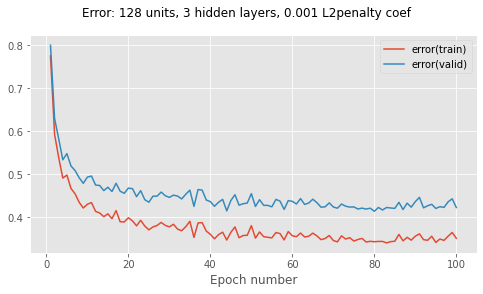

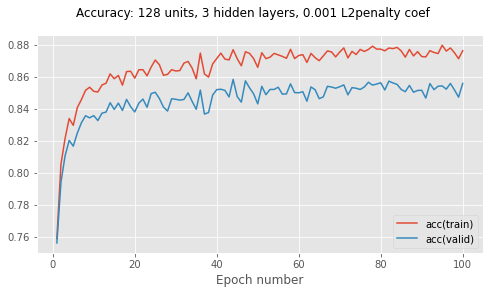

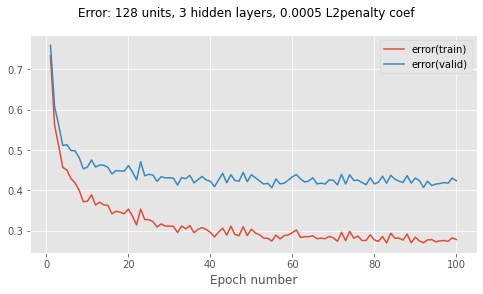

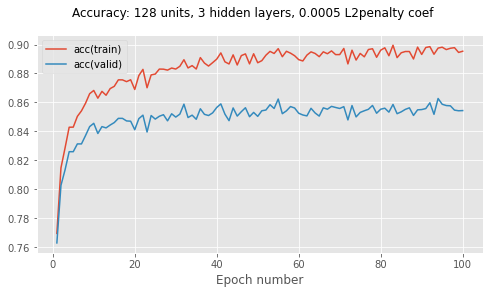

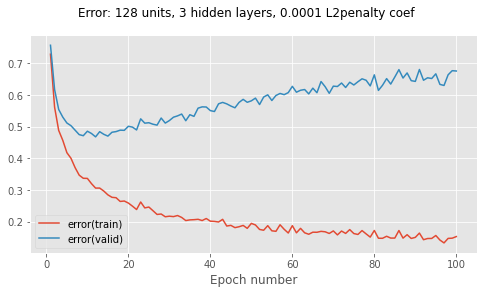

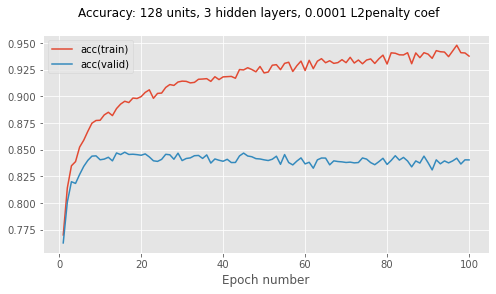

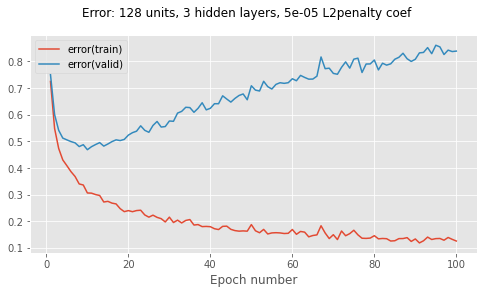

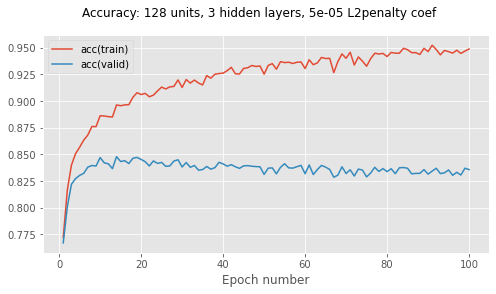

save successfully
save successfully
save successfully
save successfully


In [30]:
# 128 ReLU hidden units
# 100 epoch
# AdamLearningRule default learning rate: 1e-03
# L2Penalty coefficient [0.001, 0.001/2, 0.0001, 0.0001/2, 0.00001]

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty

#setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
L2Penalty_coefficients = [0.001, 0.001/2, 0.0001, 0.0001/2,]

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []
L2_all_stats = []
for L2Penalty_coefficient in L2Penalty_coefficients:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
                AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)),  # input layer
                ReluLayer(),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)), # hidden layer 1
                ReluLayer(),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)), # hidden layer 2
                ReluLayer(),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)), # hidden layer 3
                ReluLayer(),
                AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient))])# output layer


    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    #Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook = True)

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])
    L2_all_stats.append(stats)

    # Add figure title
    fig_1.suptitle('Error: 128 units, 3 hidden layers, {} L2penalty coef'.format(L2Penalty_coefficient))
    fig_2.suptitle('Accuracy: 128 units, 3 hidden layers, {} L2penalty coef'.format(L2Penalty_coefficient))
    # Save figure as Pdf
    fig_1.savefig('plots/L2_{0:.0e}(Err).pdf'.format(L2Penalty_coefficient))
    fig_2.savefig('plots/L2_{0:.0e}(Acc).pdf'.format(L2Penalty_coefficient))
    
plt.show()

# save data
j = 0
for L2Penalty_coefficient in L2Penalty_coefficients:
    results = {'Number of ReLU hidden units':hidden_dim,
               'Number of epochs':num_epochs,
               'Defualt learning_rate': 1e-3,
               'L2Penalty coef':L2Penalty_coefficient,
               'final error(train)':final_errors_train[j],
               'final error(valid)':final_errors_valid[j],
               'final acc(train)':final_accs_train[j],
               'final acc(valid)':final_accs_valid[j]
              }
    save_data(results,'stats/L2Penalty_{}.npy'.format(L2Penalty_coefficient))
    j += 1

In [38]:
save_data(L2_all_stats,'stats/L2.npy')

save successfully


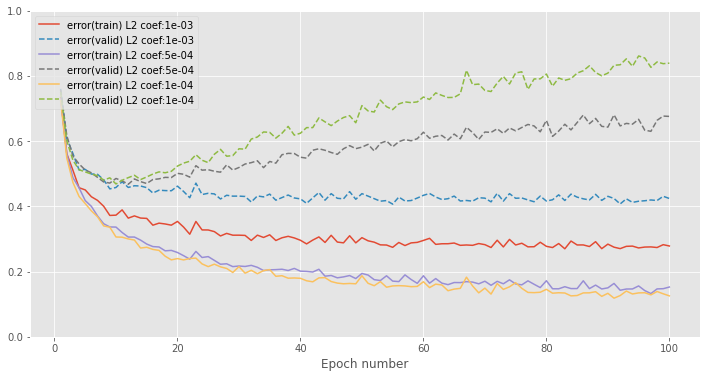

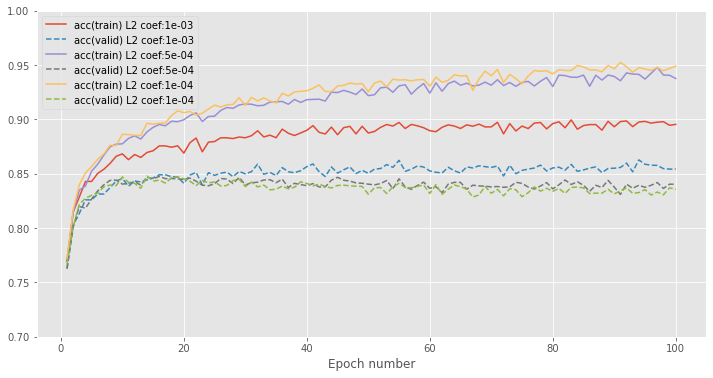

In [34]:
linestyle = ['-','--']

fig_3 = plt.figure(figsize=(12, 6))
ax_3 = fig_3.add_subplot(111)
ax_3.set_ylim([0.0,1.0])
j = 0
for stats in all_stats[1:]:
    i = 0
    for k in ['error(train)', 'error(valid)']:
        label = k + ' L2 coef:{0:.0e}'.format(L2Penalty_coefficients[j])
        ax_3.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=label,
                 ls = linestyle[i])
        i += 1
    j += 1
ax_3.legend(loc=0)
ax_3.set_xlabel('Epoch number')

fig_4 = plt.figure(figsize=(12, 6))
ax_4 = fig_4.add_subplot(111)
ax_4.set_ylim([0.7,1.0])
j = 0
for stats in all_stats[1:]:
    i = 0    
    for k in ['acc(train)', 'acc(valid)']:
        label = k + ' L2 coef:{0:.0e}'.format(L2Penalty_coefficients[j])
        ax_4.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=label,
                ls = linestyle[i])
        i += 1
    j += 1
ax_4.legend(loc=0)
ax_4.set_xlabel('Epoch number')

fig_3.savefig('plots/L2(Err).pdf')
fig_4.savefig('plots/L2(Acc).pdf')

In [ ]:
# 128 ReLU hidden units
# 100 epoch
# AdamLearningRule default learning rate: 1e-03
# Dropout: inclusion probability [0.9, 0.8, 0.7, 0.6, 0.5]

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, DropoutLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

#setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
incl_probs = [0.9, 0.8, 0.7, 0.6, 0.5]

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []
Dropout_all_stats=[]
for incl_prob in incl_probs:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
                AffineLayer(input_dim, hidden_dim, weights_init, biases_init),  # input layer
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 1
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 2
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 3
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, output_dim, weights_init, biases_init)])# output layer


    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    #Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook = True)

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])
    Dropout_all_stats.append(stats)

    # Add figure title
    fig_1.suptitle('Error: 128 units, 3 hidden layers, Dropout with {} inclusion probability'.format(incl_prob))
    fig_2.suptitle('Accuracy: 128 units, 3 hidden layers, Dropout with {} inclusion probability'.format(incl_prob))
    # Save figure as Pdf
    fig_1.savefig('plots/Dropout_p_{0:.2f}(Err).pdf'.format(incl_prob))
    fig_2.savefig('plots/Dropout_p_{0:.2f}(Acc).pdf'.format(incl_prob))
    
plt.show()

# save data
j = 0
for incl_prob in incl_probs:
    results = {'Number of ReLU hidden units':hidden_dim,
               'Number of epochs':num_epochs,
               'Defualt learning_rate': 1e-3,
               'Dropout:Inclusion prob':incl_prob,
               'final error(train)':final_errors_train[j],
               'final error(valid)':final_errors_valid[j],
               'final acc(train)':final_accs_train[j],
               'final acc(valid)':final_accs_valid[j]
              }
    save_data(results,'stats/Dropout_p_{0:.2f}.npy'.format(incl_prob))
    load_data('stats/Dropout_p_{0:.2f}.npy'.format(incl_prob))
    j += 1

Epoch 1: 5.8s to complete
    error(train)=7.96e-01, acc(train)=7.54e-01, error(valid)=8.11e-01, acc(valid)=7.48e-01


Epoch 2: 5.6s to complete
    error(train)=6.30e-01, acc(train)=7.94e-01, error(valid)=6.57e-01, acc(valid)=7.87e-01


Epoch 3: 5.8s to complete
    error(train)=5.52e-01, acc(train)=8.16e-01, error(valid)=5.90e-01, acc(valid)=8.06e-01


Epoch 4: 5.7s to complete
    error(train)=5.04e-01, acc(train)=8.28e-01, error(valid)=5.54e-01, acc(valid)=8.14e-01


Epoch 5: 5.6s to complete
    error(train)=4.62e-01, acc(train)=8.41e-01, error(valid)=5.20e-01, acc(valid)=8.22e-01


Epoch 6: 5.7s to complete
    error(train)=4.65e-01, acc(train)=8.40e-01, error(valid)=5.32e-01, acc(valid)=8.20e-01


Epoch 7: 5.6s to complete
    error(train)=4.31e-01, acc(train)=8.50e-01, error(valid)=5.03e-01, acc(valid)=8.31e-01


Epoch 8: 5.8s to complete
    error(train)=4.02e-01, acc(train)=8.58e-01, error(valid)=4.78e-01, acc(valid)=8.35e-01


Epoch 9: 5.7s to complete
    error(train)=3.91e-01, acc(train)=8.61e-01, error(valid)=4.70e-01, acc(valid)=8.40e-01


Epoch 10: 5.8s to complete
    error(train)=3.83e-01, acc(train)=8.62e-01, error(valid)=4.65e-01, acc(valid)=8.36e-01


Epoch 11: 6.0s to complete
    error(train)=3.71e-01, acc(train)=8.67e-01, error(valid)=4.55e-01, acc(valid)=8.43e-01


Epoch 12: 6.0s to complete
    error(train)=3.68e-01, acc(train)=8.69e-01, error(valid)=4.60e-01, acc(valid)=8.41e-01


Epoch 13: 5.7s to complete
    error(train)=3.57e-01, acc(train)=8.69e-01, error(valid)=4.59e-01, acc(valid)=8.43e-01


Epoch 14: 5.7s to complete
    error(train)=3.47e-01, acc(train)=8.74e-01, error(valid)=4.45e-01, acc(valid)=8.48e-01


Epoch 15: 5.9s to complete
    error(train)=3.48e-01, acc(train)=8.72e-01, error(valid)=4.60e-01, acc(valid)=8.43e-01


Epoch 16: 5.7s to complete
    error(train)=3.46e-01, acc(train)=8.73e-01, error(valid)=4.54e-01, acc(valid)=8.46e-01


Epoch 17: 5.8s to complete
    error(train)=3.28e-01, acc(train)=8.79e-01, error(valid)=4.47e-01, acc(valid)=8.49e-01


Epoch 18: 5.7s to complete
    error(train)=3.24e-01, acc(train)=8.81e-01, error(valid)=4.46e-01, acc(valid)=8.49e-01


Epoch 19: 5.8s to complete
    error(train)=3.22e-01, acc(train)=8.80e-01, error(valid)=4.42e-01, acc(valid)=8.46e-01


Epoch 20: 5.7s to complete
    error(train)=3.16e-01, acc(train)=8.82e-01, error(valid)=4.41e-01, acc(valid)=8.49e-01


Epoch 21: 5.6s to complete
    error(train)=3.15e-01, acc(train)=8.82e-01, error(valid)=4.48e-01, acc(valid)=8.46e-01


Epoch 22: 5.7s to complete
    error(train)=3.13e-01, acc(train)=8.81e-01, error(valid)=4.50e-01, acc(valid)=8.46e-01


Epoch 23: 5.7s to complete
    error(train)=3.08e-01, acc(train)=8.86e-01, error(valid)=4.41e-01, acc(valid)=8.51e-01


Epoch 24: 5.8s to complete
    error(train)=3.03e-01, acc(train)=8.87e-01, error(valid)=4.40e-01, acc(valid)=8.50e-01


Epoch 25: 6.1s to complete
    error(train)=3.02e-01, acc(train)=8.87e-01, error(valid)=4.49e-01, acc(valid)=8.50e-01


Epoch 26: 5.9s to complete
    error(train)=3.08e-01, acc(train)=8.84e-01, error(valid)=4.44e-01, acc(valid)=8.50e-01


Epoch 27: 5.7s to complete
    error(train)=2.95e-01, acc(train)=8.88e-01, error(valid)=4.36e-01, acc(valid)=8.52e-01


Epoch 28: 5.6s to complete
    error(train)=2.95e-01, acc(train)=8.89e-01, error(valid)=4.39e-01, acc(valid)=8.52e-01


Epoch 29: 6.0s to complete
    error(train)=2.90e-01, acc(train)=8.90e-01, error(valid)=4.38e-01, acc(valid)=8.50e-01


Epoch 30: 5.8s to complete
    error(train)=2.90e-01, acc(train)=8.90e-01, error(valid)=4.50e-01, acc(valid)=8.53e-01


Epoch 31: 5.9s to complete
    error(train)=2.81e-01, acc(train)=8.94e-01, error(valid)=4.35e-01, acc(valid)=8.55e-01


Epoch 32: 6.4s to complete
    error(train)=2.82e-01, acc(train)=8.92e-01, error(valid)=4.37e-01, acc(valid)=8.53e-01


Epoch 33: 6.3s to complete
    error(train)=2.88e-01, acc(train)=8.88e-01, error(valid)=4.42e-01, acc(valid)=8.50e-01


Epoch 34: 6.7s to complete
    error(train)=2.76e-01, acc(train)=8.94e-01, error(valid)=4.46e-01, acc(valid)=8.51e-01


Epoch 35: 6.4s to complete
    error(train)=2.79e-01, acc(train)=8.94e-01, error(valid)=4.41e-01, acc(valid)=8.52e-01


Epoch 36: 6.8s to complete
    error(train)=2.76e-01, acc(train)=8.94e-01, error(valid)=4.41e-01, acc(valid)=8.55e-01


Epoch 37: 6.9s to complete
    error(train)=2.80e-01, acc(train)=8.93e-01, error(valid)=4.46e-01, acc(valid)=8.51e-01


Epoch 38: 6.3s to complete
    error(train)=2.78e-01, acc(train)=8.93e-01, error(valid)=4.51e-01, acc(valid)=8.50e-01


Epoch 39: 5.9s to complete
    error(train)=2.75e-01, acc(train)=8.92e-01, error(valid)=4.44e-01, acc(valid)=8.50e-01


Epoch 40: 5.7s to complete
    error(train)=2.68e-01, acc(train)=8.97e-01, error(valid)=4.46e-01, acc(valid)=8.51e-01


Epoch 41: 6.1s to complete
    error(train)=2.68e-01, acc(train)=8.98e-01, error(valid)=4.43e-01, acc(valid)=8.52e-01


Epoch 42: 5.9s to complete
    error(train)=2.68e-01, acc(train)=8.96e-01, error(valid)=4.46e-01, acc(valid)=8.51e-01


Epoch 43: 5.8s to complete
    error(train)=2.69e-01, acc(train)=8.96e-01, error(valid)=4.57e-01, acc(valid)=8.52e-01


Epoch 44: 6.2s to complete
    error(train)=2.64e-01, acc(train)=8.98e-01, error(valid)=4.47e-01, acc(valid)=8.54e-01


Epoch 45: 5.8s to complete
    error(train)=2.66e-01, acc(train)=8.97e-01, error(valid)=4.51e-01, acc(valid)=8.51e-01


Epoch 46: 5.9s to complete
    error(train)=2.61e-01, acc(train)=8.99e-01, error(valid)=4.51e-01, acc(valid)=8.53e-01


Epoch 47: 5.8s to complete
    error(train)=2.60e-01, acc(train)=8.99e-01, error(valid)=4.46e-01, acc(valid)=8.53e-01


Epoch 48: 6.1s to complete
    error(train)=2.58e-01, acc(train)=9.00e-01, error(valid)=4.51e-01, acc(valid)=8.53e-01


Epoch 49: 6.0s to complete
    error(train)=2.57e-01, acc(train)=9.00e-01, error(valid)=4.45e-01, acc(valid)=8.51e-01


Epoch 50: 5.7s to complete
    error(train)=2.59e-01, acc(train)=8.99e-01, error(valid)=4.50e-01, acc(valid)=8.53e-01


Epoch 51: 6.0s to complete
    error(train)=2.53e-01, acc(train)=9.01e-01, error(valid)=4.52e-01, acc(valid)=8.51e-01


Epoch 52: 6.0s to complete
    error(train)=2.58e-01, acc(train)=8.99e-01, error(valid)=4.52e-01, acc(valid)=8.52e-01


Epoch 53: 5.9s to complete
    error(train)=2.56e-01, acc(train)=9.00e-01, error(valid)=4.49e-01, acc(valid)=8.51e-01


Epoch 54: 5.9s to complete
    error(train)=2.51e-01, acc(train)=9.01e-01, error(valid)=4.46e-01, acc(valid)=8.53e-01


Epoch 55: 5.9s to complete
    error(train)=2.53e-01, acc(train)=9.01e-01, error(valid)=4.46e-01, acc(valid)=8.52e-01


Epoch 56: 5.8s to complete
    error(train)=2.56e-01, acc(train)=8.99e-01, error(valid)=4.60e-01, acc(valid)=8.48e-01


Epoch 57: 6.0s to complete
    error(train)=2.51e-01, acc(train)=9.01e-01, error(valid)=4.42e-01, acc(valid)=8.54e-01


Epoch 58: 5.9s to complete
    error(train)=2.49e-01, acc(train)=9.02e-01, error(valid)=4.47e-01, acc(valid)=8.52e-01


Epoch 59: 5.8s to complete
    error(train)=2.45e-01, acc(train)=9.02e-01, error(valid)=4.52e-01, acc(valid)=8.53e-01


Epoch 60: 5.9s to complete
    error(train)=2.48e-01, acc(train)=9.03e-01, error(valid)=4.50e-01, acc(valid)=8.52e-01


Epoch 61: 5.8s to complete
    error(train)=2.47e-01, acc(train)=9.02e-01, error(valid)=4.58e-01, acc(valid)=8.53e-01


Epoch 62: 5.9s to complete
    error(train)=2.48e-01, acc(train)=9.02e-01, error(valid)=4.46e-01, acc(valid)=8.56e-01


Epoch 63: 6.0s to complete
    error(train)=2.45e-01, acc(train)=9.04e-01, error(valid)=4.50e-01, acc(valid)=8.53e-01


Epoch 64: 5.7s to complete
    error(train)=2.43e-01, acc(train)=9.04e-01, error(valid)=4.51e-01, acc(valid)=8.55e-01


Epoch 65: 5.9s to complete
    error(train)=2.45e-01, acc(train)=9.03e-01, error(valid)=4.52e-01, acc(valid)=8.55e-01


Epoch 66: 6.0s to complete
    error(train)=2.43e-01, acc(train)=9.05e-01, error(valid)=4.46e-01, acc(valid)=8.54e-01


Epoch 67: 5.9s to complete
    error(train)=2.40e-01, acc(train)=9.05e-01, error(valid)=4.55e-01, acc(valid)=8.54e-01


Epoch 68: 5.9s to complete
    error(train)=2.41e-01, acc(train)=9.06e-01, error(valid)=4.49e-01, acc(valid)=8.53e-01


Epoch 69: 5.9s to complete
    error(train)=2.39e-01, acc(train)=9.07e-01, error(valid)=4.44e-01, acc(valid)=8.56e-01


Epoch 70: 5.9s to complete
    error(train)=2.40e-01, acc(train)=9.06e-01, error(valid)=4.49e-01, acc(valid)=8.54e-01


Epoch 71: 5.9s to complete
    error(train)=2.40e-01, acc(train)=9.06e-01, error(valid)=4.59e-01, acc(valid)=8.54e-01


Epoch 72: 6.0s to complete
    error(train)=2.39e-01, acc(train)=9.06e-01, error(valid)=4.50e-01, acc(valid)=8.53e-01


Epoch 73: 5.9s to complete
    error(train)=2.37e-01, acc(train)=9.05e-01, error(valid)=4.51e-01, acc(valid)=8.52e-01


Epoch 74: 5.8s to complete
    error(train)=2.33e-01, acc(train)=9.08e-01, error(valid)=4.56e-01, acc(valid)=8.54e-01


Epoch 75: 5.8s to complete
    error(train)=2.34e-01, acc(train)=9.07e-01, error(valid)=4.54e-01, acc(valid)=8.54e-01


Epoch 76: 6.0s to complete
    error(train)=2.34e-01, acc(train)=9.07e-01, error(valid)=4.49e-01, acc(valid)=8.56e-01


Epoch 77: 5.7s to complete
    error(train)=2.37e-01, acc(train)=9.06e-01, error(valid)=4.58e-01, acc(valid)=8.53e-01


Epoch 78: 5.9s to complete
    error(train)=2.26e-01, acc(train)=9.11e-01, error(valid)=4.48e-01, acc(valid)=8.56e-01


Epoch 79: 5.8s to complete
    error(train)=2.38e-01, acc(train)=9.07e-01, error(valid)=4.60e-01, acc(valid)=8.52e-01


Epoch 80: 5.9s to complete
    error(train)=2.41e-01, acc(train)=9.05e-01, error(valid)=4.54e-01, acc(valid)=8.49e-01


Epoch 81: 6.0s to complete
    error(train)=2.28e-01, acc(train)=9.09e-01, error(valid)=4.51e-01, acc(valid)=8.54e-01


Epoch 82: 5.9s to complete
    error(train)=2.33e-01, acc(train)=9.08e-01, error(valid)=4.57e-01, acc(valid)=8.53e-01


Epoch 83: 6.1s to complete
    error(train)=2.30e-01, acc(train)=9.08e-01, error(valid)=4.61e-01, acc(valid)=8.54e-01


Epoch 84: 5.9s to complete
    error(train)=2.33e-01, acc(train)=9.08e-01, error(valid)=4.64e-01, acc(valid)=8.52e-01


Epoch 85: 5.7s to complete
    error(train)=2.30e-01, acc(train)=9.08e-01, error(valid)=4.59e-01, acc(valid)=8.52e-01


Epoch 86: 5.8s to complete
    error(train)=2.30e-01, acc(train)=9.08e-01, error(valid)=4.59e-01, acc(valid)=8.52e-01


Epoch 87: 5.8s to complete
    error(train)=2.29e-01, acc(train)=9.11e-01, error(valid)=4.60e-01, acc(valid)=8.55e-01


Epoch 88: 6.1s to complete
    error(train)=2.32e-01, acc(train)=9.09e-01, error(valid)=4.64e-01, acc(valid)=8.53e-01


Epoch 89: 5.8s to complete
    error(train)=2.29e-01, acc(train)=9.08e-01, error(valid)=4.59e-01, acc(valid)=8.54e-01


Epoch 90: 5.8s to complete
    error(train)=2.27e-01, acc(train)=9.11e-01, error(valid)=4.63e-01, acc(valid)=8.54e-01


Epoch 91: 5.8s to complete
    error(train)=2.31e-01, acc(train)=9.09e-01, error(valid)=4.58e-01, acc(valid)=8.52e-01


Epoch 92: 5.9s to complete
    error(train)=2.27e-01, acc(train)=9.09e-01, error(valid)=4.67e-01, acc(valid)=8.55e-01


Epoch 93: 5.9s to complete
    error(train)=2.23e-01, acc(train)=9.12e-01, error(valid)=4.58e-01, acc(valid)=8.56e-01


Epoch 94: 5.8s to complete
    error(train)=2.28e-01, acc(train)=9.09e-01, error(valid)=4.57e-01, acc(valid)=8.55e-01


Epoch 95: 5.7s to complete
    error(train)=2.27e-01, acc(train)=9.10e-01, error(valid)=4.60e-01, acc(valid)=8.51e-01


Epoch 96: 5.7s to complete
    error(train)=2.22e-01, acc(train)=9.12e-01, error(valid)=4.56e-01, acc(valid)=8.55e-01


Epoch 97: 5.8s to complete
    error(train)=2.24e-01, acc(train)=9.10e-01, error(valid)=4.60e-01, acc(valid)=8.51e-01


Epoch 98: 5.8s to complete
    error(train)=2.24e-01, acc(train)=9.10e-01, error(valid)=4.59e-01, acc(valid)=8.55e-01


Epoch 99: 6.1s to complete
    error(train)=2.25e-01, acc(train)=9.12e-01, error(valid)=4.67e-01, acc(valid)=8.55e-01


Epoch 100: 5.9s to complete
    error(train)=2.25e-01, acc(train)=9.10e-01, error(valid)=4.69e-01, acc(valid)=8.54e-01


Epoch 1: 5.8s to complete
    error(train)=9.40e-01, acc(train)=7.13e-01, error(valid)=9.53e-01, acc(valid)=7.11e-01


Epoch 2: 5.7s to complete
    error(train)=7.28e-01, acc(train)=7.65e-01, error(valid)=7.48e-01, acc(valid)=7.60e-01


Epoch 3: 5.8s to complete
    error(train)=6.52e-01, acc(train)=7.89e-01, error(valid)=6.81e-01, acc(valid)=7.81e-01


Epoch 4: 5.8s to complete
    error(train)=5.90e-01, acc(train)=8.03e-01, error(valid)=6.17e-01, acc(valid)=7.99e-01


Epoch 5: 5.8s to complete
    error(train)=5.49e-01, acc(train)=8.16e-01, error(valid)=5.83e-01, acc(valid)=8.07e-01


Epoch 6: 5.7s to complete
    error(train)=5.27e-01, acc(train)=8.21e-01, error(valid)=5.65e-01, acc(valid)=8.10e-01


Epoch 7: 5.7s to complete
    error(train)=5.05e-01, acc(train)=8.30e-01, error(valid)=5.49e-01, acc(valid)=8.19e-01


Epoch 8: 5.8s to complete
    error(train)=4.91e-01, acc(train)=8.32e-01, error(valid)=5.36e-01, acc(valid)=8.21e-01


Epoch 9: 5.8s to complete
    error(train)=4.70e-01, acc(train)=8.37e-01, error(valid)=5.22e-01, acc(valid)=8.24e-01


Epoch 10: 5.7s to complete
    error(train)=4.59e-01, acc(train)=8.40e-01, error(valid)=5.09e-01, acc(valid)=8.26e-01


Epoch 11: 5.9s to complete
    error(train)=4.51e-01, acc(train)=8.43e-01, error(valid)=5.05e-01, acc(valid)=8.29e-01


Epoch 12: 5.8s to complete
    error(train)=4.45e-01, acc(train)=8.44e-01, error(valid)=5.08e-01, acc(valid)=8.29e-01


Epoch 13: 5.7s to complete
    error(train)=4.35e-01, acc(train)=8.47e-01, error(valid)=5.01e-01, acc(valid)=8.32e-01


Epoch 14: 5.9s to complete
    error(train)=4.24e-01, acc(train)=8.52e-01, error(valid)=4.92e-01, acc(valid)=8.34e-01


Epoch 15: 5.9s to complete
    error(train)=4.18e-01, acc(train)=8.53e-01, error(valid)=4.92e-01, acc(valid)=8.33e-01


Epoch 16: 5.7s to complete
    error(train)=4.15e-01, acc(train)=8.53e-01, error(valid)=4.86e-01, acc(valid)=8.34e-01


Epoch 17: 5.8s to complete
    error(train)=4.03e-01, acc(train)=8.57e-01, error(valid)=4.76e-01, acc(valid)=8.38e-01


Epoch 18: 5.9s to complete
    error(train)=4.02e-01, acc(train)=8.55e-01, error(valid)=4.82e-01, acc(valid)=8.36e-01


Epoch 19: 5.7s to complete
    error(train)=3.95e-01, acc(train)=8.58e-01, error(valid)=4.76e-01, acc(valid)=8.37e-01


Epoch 20: 5.9s to complete
    error(train)=3.96e-01, acc(train)=8.56e-01, error(valid)=4.77e-01, acc(valid)=8.39e-01


In [ ]:
# 128 ReLU hidden units
# 100 epoch
# AdamLearningRule default learning rate: 1e-03
# Dropout: inclusion probability [0.9]
# L1 penalty, 1e-04/2(OR 1e-05)

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, DropoutLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser
from mlp.penalties import L1Penalty

#setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
incl_probs = [0.9]
L1Penalty_coefficient = 1e-05

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []
for incl_prob in incl_probs:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
                AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient)),  # input layer
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient)), # hidden layer 1
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient)), # hidden layer 2
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient)), # hidden layer 3
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=L1Penalty(L1Penalty_coefficient))])# output layer


    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    #Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook = True)

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

    # Add figure title
    fig_1.suptitle('Error:Dropout with {} inclusion probability, L1 penalty constant {}'.format(incl_prob,L1Penalty_coefficient))
    fig_2.suptitle('Accuracy:Dropout with {} inclusion probability, L1 penalty constant {}'.format(incl_prob,L1Penalty_coefficient))
    # Save figure as Pdf
    fig_1.savefig('plots/Dropout_p_{0:.2f}_L1{1:.0e}(Err).pdf'.format(incl_prob,L1Penalty_coefficient))
    fig_2.savefig('plots/Dropout_p_{0:.2f}_L1{1:.0e}(Acc).pdf'.format(incl_prob,L1Penalty_coefficient))
    
plt.show()

# save data
j = 0
for incl_prob in incl_probs:
    results = {'Number of ReLU hidden units':hidden_dim,
               'Number of epochs':num_epochs,
               'Defualt learning_rate': 1e-3,
               'Dropout:Inclusion prob':incl_prob,
               'Weight penalty: L1':L1Penalty_coefficient,
               'final error(train)':final_errors_train[j],
               'final error(valid)':final_errors_valid[j],
               'final acc(train)':final_accs_train[j],
               'final acc(valid)':final_accs_valid[j]
              }
    save_data(results,'stats/Dropout_p_{0:.2f}_L1{1:.0e}.npy'.format(incl_prob,L1Penalty_coefficient))
    j += 1

In [ ]:
# 128 ReLU hidden units
# 100 epoch
# AdamLearningRule default learning rate: 1e-03
# Dropout: inclusion probability [0.9]
# L2 penalty, 1e-03/2(OR 1e-04)

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, DropoutLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty

#setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
incl_probs = [0.9]
L2Penalty_coefficient = 1e-04

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []
for incl_prob in incl_probs:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
                AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)),  # input layer
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)), # hidden layer 1
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)), # hidden layer 2
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)), # hidden layer 3
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient))])# output layer


    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    #Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook = True)

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

    # Add figure title
    fig_1.suptitle('Error:Dropout with {} inclusion probability, L2 penalty constant {}'.format(incl_prob,L2Penalty_coefficient))
    fig_2.suptitle('Accuracy:Dropout with {} inclusion probability, L2 penalty constant {}'.format(incl_prob,L2Penalty_coefficient))
    # Save figure as Pdf
    fig_1.savefig('plots/Dropout_p_{0:.2f}_L2{1:.0e}(Err).pdf'.format(incl_prob,L2Penalty_coefficient))
    fig_2.savefig('plots/Dropout_p_{0:.2f}_L2{1:.0e}(Acc).pdf'.format(incl_prob,L2Penalty_coefficient))
    
plt.show()

# save data
j = 0
for incl_prob in incl_probs:
    results = {'Number of ReLU hidden units':hidden_dim,
               'Number of epochs':num_epochs,
               'Defualt learning_rate': 1e-3,
               'Dropout:Inclusion prob':incl_prob,
               'Weight penalty: L2':L2Penalty_coefficient,
               'final error(train)':final_errors_train[j],
               'final error(valid)':final_errors_valid[j],
               'final acc(train)':final_accs_train[j],
               'final acc(valid)':final_accs_valid[j]
              }
    save_data(results,'stats/Dropout_p_{0:.2f}_L2{1:.0e}.npy'.format(incl_prob,L2Penalty_coefficient))
    j += 1

In [ ]:
# 128 ReLU hidden units
# 100 epoch
# AdamLearningRule default learning rate: 1e-03/2
# Dropout: inclusion probability [0.9]
# L2 penalty, 1e-03/2(OR 1e-04)

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, DropoutLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty

#setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
incl_probs = [0.9]
L2Penalty_coefficient = 1e-04
learning_rate = 1e-04

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []
for incl_prob in incl_probs:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
                AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)),  # input layer
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)), # hidden layer 1
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)), # hidden layer 2
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient)), # hidden layer 3
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=L2Penalty(L2Penalty_coefficient))])# output layer


    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule(learning_rate = learning_rate)

    #Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook = True)

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

    # Add figure title
    fig_1.suptitle('Error:Dropout incl_prob = {0}, L2 constant {1:.0e},learning_rate{2:.0e}'.format(incl_prob,L2Penalty_coefficient,learning_rate))
    fig_2.suptitle('Accuracy:Dropout incl_prob = {0}, L2 constant {1:.0e}, learning_rate{2:.0e}'.format(incl_prob,L2Penalty_coefficient,learning_rate))
    # Save figure as Pdf
    fig_1.savefig('plots/Dropout_p_{0:.2f}_L2{1:.0e}_lr{2:.0e}(Err).pdf'.format(incl_prob,L2Penalty_coefficient,learning_rate))
    fig_2.savefig('plots/Dropout_p_{0:.2f}_L2{1:.0e}_lr{2:.0e}(Acc).pdf'.format(incl_prob,L2Penalty_coefficient,learning_rate))
    
plt.show()

# save data
j = 0
for incl_prob in incl_probs:
    results = {'Number of ReLU hidden units':hidden_dim,
               'Number of epochs':num_epochs,
               'Learning_rate': learning_rate,
               'Dropout:Inclusion prob':incl_prob,
               'Weight penalty: L2':L2Penalty_coefficient,
               'final error(train)':final_errors_train[j],
               'final error(valid)':final_errors_valid[j],
               'final acc(train)':final_accs_train[j],
               'final acc(valid)':final_accs_valid[j]
              }
    save_data(results,'stats/Dropout_p_{0:.2f}_L2{1:.0e}_lr{2:.0e}.npy'.format(incl_prob,L2Penalty_coefficient,learning_rate))
    j += 1

Epoch 1: 5.7s to complete
    error(train)=7.96e-01, acc(train)=7.54e-01, error(valid)=8.11e-01, acc(valid)=7.48e-01


Epoch 2: 5.5s to complete
    error(train)=6.30e-01, acc(train)=7.94e-01, error(valid)=6.57e-01, acc(valid)=7.87e-01


Epoch 3: 5.8s to complete
    error(train)=5.52e-01, acc(train)=8.16e-01, error(valid)=5.90e-01, acc(valid)=8.06e-01


Epoch 4: 5.7s to complete
    error(train)=5.04e-01, acc(train)=8.28e-01, error(valid)=5.54e-01, acc(valid)=8.14e-01


Epoch 5: 5.9s to complete
    error(train)=4.62e-01, acc(train)=8.41e-01, error(valid)=5.20e-01, acc(valid)=8.22e-01


Epoch 6: 5.8s to complete
    error(train)=4.65e-01, acc(train)=8.40e-01, error(valid)=5.32e-01, acc(valid)=8.20e-01


Epoch 7: 5.8s to complete
    error(train)=4.31e-01, acc(train)=8.50e-01, error(valid)=5.03e-01, acc(valid)=8.31e-01


Epoch 8: 5.7s to complete
    error(train)=4.02e-01, acc(train)=8.58e-01, error(valid)=4.78e-01, acc(valid)=8.35e-01


Epoch 9: 5.9s to complete
    error(train)=3.91e-01, acc(train)=8.61e-01, error(valid)=4.70e-01, acc(valid)=8.40e-01


Epoch 10: 5.8s to complete
    error(train)=3.83e-01, acc(train)=8.62e-01, error(valid)=4.65e-01, acc(valid)=8.36e-01


Epoch 11: 6.0s to complete
    error(train)=3.71e-01, acc(train)=8.67e-01, error(valid)=4.55e-01, acc(valid)=8.43e-01


Epoch 12: 5.9s to complete
    error(train)=3.68e-01, acc(train)=8.69e-01, error(valid)=4.60e-01, acc(valid)=8.41e-01


Epoch 13: 6.3s to complete
    error(train)=3.57e-01, acc(train)=8.69e-01, error(valid)=4.59e-01, acc(valid)=8.43e-01


Epoch 14: 5.8s to complete
    error(train)=3.47e-01, acc(train)=8.74e-01, error(valid)=4.45e-01, acc(valid)=8.48e-01


Epoch 15: 5.6s to complete
    error(train)=3.48e-01, acc(train)=8.72e-01, error(valid)=4.60e-01, acc(valid)=8.43e-01


Epoch 16: 5.9s to complete
    error(train)=3.46e-01, acc(train)=8.73e-01, error(valid)=4.54e-01, acc(valid)=8.46e-01


Epoch 17: 6.1s to complete
    error(train)=3.28e-01, acc(train)=8.79e-01, error(valid)=4.47e-01, acc(valid)=8.49e-01


Epoch 18: 5.8s to complete
    error(train)=3.24e-01, acc(train)=8.81e-01, error(valid)=4.46e-01, acc(valid)=8.49e-01


Epoch 19: 6.0s to complete
    error(train)=3.22e-01, acc(train)=8.80e-01, error(valid)=4.42e-01, acc(valid)=8.46e-01


Epoch 20: 5.9s to complete
    error(train)=3.16e-01, acc(train)=8.82e-01, error(valid)=4.41e-01, acc(valid)=8.49e-01


Epoch 21: 6.0s to complete
    error(train)=3.15e-01, acc(train)=8.82e-01, error(valid)=4.48e-01, acc(valid)=8.46e-01


Epoch 22: 6.1s to complete
    error(train)=3.13e-01, acc(train)=8.81e-01, error(valid)=4.50e-01, acc(valid)=8.46e-01


Epoch 23: 5.8s to complete
    error(train)=3.08e-01, acc(train)=8.86e-01, error(valid)=4.41e-01, acc(valid)=8.51e-01


Epoch 24: 6.2s to complete
    error(train)=3.03e-01, acc(train)=8.87e-01, error(valid)=4.40e-01, acc(valid)=8.50e-01


Epoch 25: 6.0s to complete
    error(train)=3.02e-01, acc(train)=8.87e-01, error(valid)=4.49e-01, acc(valid)=8.50e-01


Epoch 26: 5.8s to complete
    error(train)=3.08e-01, acc(train)=8.84e-01, error(valid)=4.44e-01, acc(valid)=8.50e-01


Epoch 27: 6.0s to complete
    error(train)=2.95e-01, acc(train)=8.88e-01, error(valid)=4.36e-01, acc(valid)=8.52e-01


Epoch 28: 6.3s to complete
    error(train)=2.95e-01, acc(train)=8.89e-01, error(valid)=4.39e-01, acc(valid)=8.52e-01


Epoch 29: 6.0s to complete
    error(train)=2.90e-01, acc(train)=8.90e-01, error(valid)=4.38e-01, acc(valid)=8.50e-01


Epoch 30: 6.0s to complete
    error(train)=2.90e-01, acc(train)=8.90e-01, error(valid)=4.50e-01, acc(valid)=8.53e-01


Epoch 31: 5.9s to complete
    error(train)=2.81e-01, acc(train)=8.94e-01, error(valid)=4.35e-01, acc(valid)=8.55e-01


Epoch 32: 6.2s to complete
    error(train)=2.82e-01, acc(train)=8.92e-01, error(valid)=4.37e-01, acc(valid)=8.53e-01


Epoch 33: 6.6s to complete
    error(train)=2.88e-01, acc(train)=8.88e-01, error(valid)=4.42e-01, acc(valid)=8.50e-01


Epoch 34: 6.9s to complete
    error(train)=2.76e-01, acc(train)=8.94e-01, error(valid)=4.46e-01, acc(valid)=8.51e-01


Epoch 35: 6.5s to complete
    error(train)=2.79e-01, acc(train)=8.94e-01, error(valid)=4.41e-01, acc(valid)=8.52e-01


Epoch 36: 6.7s to complete
    error(train)=2.76e-01, acc(train)=8.94e-01, error(valid)=4.41e-01, acc(valid)=8.55e-01


Epoch 37: 7.2s to complete
    error(train)=2.80e-01, acc(train)=8.93e-01, error(valid)=4.46e-01, acc(valid)=8.51e-01


Epoch 38: 6.4s to complete
    error(train)=2.78e-01, acc(train)=8.93e-01, error(valid)=4.51e-01, acc(valid)=8.50e-01


Epoch 39: 6.3s to complete
    error(train)=2.75e-01, acc(train)=8.92e-01, error(valid)=4.44e-01, acc(valid)=8.50e-01


Epoch 40: 6.2s to complete
    error(train)=2.68e-01, acc(train)=8.97e-01, error(valid)=4.46e-01, acc(valid)=8.51e-01


Epoch 41: 6.1s to complete
    error(train)=2.68e-01, acc(train)=8.98e-01, error(valid)=4.43e-01, acc(valid)=8.52e-01


Epoch 42: 5.9s to complete
    error(train)=2.68e-01, acc(train)=8.96e-01, error(valid)=4.46e-01, acc(valid)=8.51e-01


Epoch 43: 5.8s to complete
    error(train)=2.69e-01, acc(train)=8.96e-01, error(valid)=4.57e-01, acc(valid)=8.52e-01


Epoch 44: 5.8s to complete
    error(train)=2.64e-01, acc(train)=8.98e-01, error(valid)=4.47e-01, acc(valid)=8.54e-01


Epoch 45: 5.9s to complete
    error(train)=2.66e-01, acc(train)=8.97e-01, error(valid)=4.51e-01, acc(valid)=8.51e-01


Epoch 46: 5.9s to complete
    error(train)=2.61e-01, acc(train)=8.99e-01, error(valid)=4.51e-01, acc(valid)=8.53e-01


Epoch 47: 5.8s to complete
    error(train)=2.60e-01, acc(train)=8.99e-01, error(valid)=4.46e-01, acc(valid)=8.53e-01


Epoch 48: 5.8s to complete
    error(train)=2.58e-01, acc(train)=9.00e-01, error(valid)=4.51e-01, acc(valid)=8.53e-01


Epoch 49: 5.8s to complete
    error(train)=2.57e-01, acc(train)=9.00e-01, error(valid)=4.45e-01, acc(valid)=8.51e-01


Epoch 50: 6.1s to complete
    error(train)=2.59e-01, acc(train)=8.99e-01, error(valid)=4.50e-01, acc(valid)=8.53e-01


Epoch 51: 5.9s to complete
    error(train)=2.53e-01, acc(train)=9.01e-01, error(valid)=4.52e-01, acc(valid)=8.51e-01


Epoch 52: 5.8s to complete
    error(train)=2.58e-01, acc(train)=8.99e-01, error(valid)=4.52e-01, acc(valid)=8.52e-01


Epoch 53: 6.0s to complete
    error(train)=2.56e-01, acc(train)=9.00e-01, error(valid)=4.49e-01, acc(valid)=8.51e-01


Epoch 54: 6.3s to complete
    error(train)=2.51e-01, acc(train)=9.01e-01, error(valid)=4.46e-01, acc(valid)=8.53e-01


Epoch 55: 5.9s to complete
    error(train)=2.53e-01, acc(train)=9.01e-01, error(valid)=4.46e-01, acc(valid)=8.52e-01


Epoch 56: 5.7s to complete
    error(train)=2.56e-01, acc(train)=8.99e-01, error(valid)=4.60e-01, acc(valid)=8.48e-01


Epoch 57: 6.0s to complete
    error(train)=2.51e-01, acc(train)=9.01e-01, error(valid)=4.42e-01, acc(valid)=8.54e-01


Epoch 58: 5.9s to complete
    error(train)=2.49e-01, acc(train)=9.02e-01, error(valid)=4.47e-01, acc(valid)=8.52e-01


Epoch 59: 6.0s to complete
    error(train)=2.45e-01, acc(train)=9.02e-01, error(valid)=4.52e-01, acc(valid)=8.53e-01


Epoch 60: 6.0s to complete
    error(train)=2.48e-01, acc(train)=9.03e-01, error(valid)=4.50e-01, acc(valid)=8.52e-01


Epoch 61: 6.0s to complete
    error(train)=2.47e-01, acc(train)=9.02e-01, error(valid)=4.58e-01, acc(valid)=8.53e-01


Epoch 62: 5.8s to complete
    error(train)=2.48e-01, acc(train)=9.02e-01, error(valid)=4.46e-01, acc(valid)=8.56e-01


Epoch 63: 5.8s to complete
    error(train)=2.45e-01, acc(train)=9.04e-01, error(valid)=4.50e-01, acc(valid)=8.53e-01


Epoch 64: 5.8s to complete
    error(train)=2.43e-01, acc(train)=9.04e-01, error(valid)=4.51e-01, acc(valid)=8.55e-01


Epoch 65: 5.7s to complete
    error(train)=2.45e-01, acc(train)=9.03e-01, error(valid)=4.52e-01, acc(valid)=8.55e-01


Epoch 66: 5.9s to complete
    error(train)=2.43e-01, acc(train)=9.05e-01, error(valid)=4.46e-01, acc(valid)=8.54e-01


Epoch 67: 5.8s to complete
    error(train)=2.40e-01, acc(train)=9.05e-01, error(valid)=4.55e-01, acc(valid)=8.54e-01


Epoch 68: 6.2s to complete
    error(train)=2.41e-01, acc(train)=9.06e-01, error(valid)=4.49e-01, acc(valid)=8.53e-01


Epoch 69: 6.0s to complete
    error(train)=2.39e-01, acc(train)=9.07e-01, error(valid)=4.44e-01, acc(valid)=8.56e-01


Epoch 70: 5.9s to complete
    error(train)=2.40e-01, acc(train)=9.06e-01, error(valid)=4.49e-01, acc(valid)=8.54e-01


Epoch 71: 5.9s to complete
    error(train)=2.40e-01, acc(train)=9.06e-01, error(valid)=4.59e-01, acc(valid)=8.54e-01


Epoch 72: 6.0s to complete
    error(train)=2.39e-01, acc(train)=9.06e-01, error(valid)=4.50e-01, acc(valid)=8.53e-01


Epoch 73: 5.8s to complete
    error(train)=2.37e-01, acc(train)=9.05e-01, error(valid)=4.51e-01, acc(valid)=8.52e-01


Epoch 74: 6.2s to complete
    error(train)=2.33e-01, acc(train)=9.08e-01, error(valid)=4.56e-01, acc(valid)=8.54e-01


Epoch 75: 5.9s to complete
    error(train)=2.34e-01, acc(train)=9.07e-01, error(valid)=4.54e-01, acc(valid)=8.54e-01


Epoch 76: 6.1s to complete
    error(train)=2.34e-01, acc(train)=9.07e-01, error(valid)=4.49e-01, acc(valid)=8.56e-01


Epoch 77: 6.0s to complete
    error(train)=2.37e-01, acc(train)=9.06e-01, error(valid)=4.58e-01, acc(valid)=8.53e-01


Epoch 78: 5.8s to complete
    error(train)=2.26e-01, acc(train)=9.11e-01, error(valid)=4.48e-01, acc(valid)=8.56e-01


Epoch 79: 5.8s to complete
    error(train)=2.38e-01, acc(train)=9.07e-01, error(valid)=4.60e-01, acc(valid)=8.52e-01


Epoch 80: 5.9s to complete
    error(train)=2.41e-01, acc(train)=9.05e-01, error(valid)=4.54e-01, acc(valid)=8.49e-01


Epoch 81: 6.0s to complete
    error(train)=2.28e-01, acc(train)=9.09e-01, error(valid)=4.51e-01, acc(valid)=8.54e-01


Epoch 82: 6.0s to complete
    error(train)=2.33e-01, acc(train)=9.08e-01, error(valid)=4.57e-01, acc(valid)=8.53e-01


Epoch 83: 5.9s to complete
    error(train)=2.30e-01, acc(train)=9.08e-01, error(valid)=4.61e-01, acc(valid)=8.54e-01


Epoch 84: 6.1s to complete
    error(train)=2.33e-01, acc(train)=9.08e-01, error(valid)=4.64e-01, acc(valid)=8.52e-01


Epoch 85: 5.8s to complete
    error(train)=2.30e-01, acc(train)=9.08e-01, error(valid)=4.59e-01, acc(valid)=8.52e-01


Epoch 86: 5.8s to complete
    error(train)=2.30e-01, acc(train)=9.08e-01, error(valid)=4.59e-01, acc(valid)=8.52e-01


Epoch 87: 5.9s to complete
    error(train)=2.29e-01, acc(train)=9.11e-01, error(valid)=4.60e-01, acc(valid)=8.55e-01


Epoch 88: 6.0s to complete
    error(train)=2.32e-01, acc(train)=9.09e-01, error(valid)=4.64e-01, acc(valid)=8.53e-01


Epoch 89: 5.8s to complete
    error(train)=2.29e-01, acc(train)=9.08e-01, error(valid)=4.59e-01, acc(valid)=8.54e-01


Epoch 90: 5.8s to complete
    error(train)=2.27e-01, acc(train)=9.11e-01, error(valid)=4.63e-01, acc(valid)=8.54e-01


Epoch 91: 5.8s to complete
    error(train)=2.31e-01, acc(train)=9.09e-01, error(valid)=4.58e-01, acc(valid)=8.52e-01


Epoch 92: 5.8s to complete
    error(train)=2.27e-01, acc(train)=9.09e-01, error(valid)=4.67e-01, acc(valid)=8.55e-01


Epoch 93: 6.1s to complete
    error(train)=2.23e-01, acc(train)=9.12e-01, error(valid)=4.58e-01, acc(valid)=8.56e-01


Epoch 94: 6.0s to complete
    error(train)=2.28e-01, acc(train)=9.09e-01, error(valid)=4.57e-01, acc(valid)=8.55e-01


Epoch 95: 5.9s to complete
    error(train)=2.27e-01, acc(train)=9.10e-01, error(valid)=4.60e-01, acc(valid)=8.51e-01


Epoch 96: 5.9s to complete
    error(train)=2.22e-01, acc(train)=9.12e-01, error(valid)=4.56e-01, acc(valid)=8.55e-01


Epoch 97: 5.8s to complete
    error(train)=2.24e-01, acc(train)=9.10e-01, error(valid)=4.60e-01, acc(valid)=8.51e-01


Epoch 98: 6.2s to complete
    error(train)=2.24e-01, acc(train)=9.10e-01, error(valid)=4.59e-01, acc(valid)=8.55e-01


Epoch 99: 5.9s to complete
    error(train)=2.25e-01, acc(train)=9.12e-01, error(valid)=4.67e-01, acc(valid)=8.55e-01


Epoch 100: 5.9s to complete
    error(train)=2.25e-01, acc(train)=9.10e-01, error(valid)=4.69e-01, acc(valid)=8.54e-01


IndexError: Replacement index 2 out of range for positional args tuple

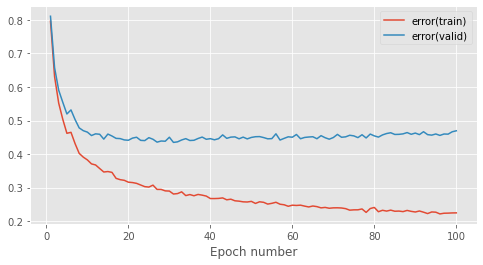

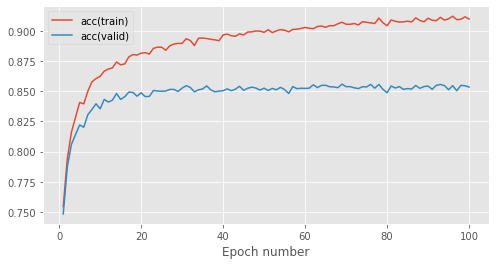

In [4]:
# 128 ReLU hidden units
# 100 epoch
# AdamLearningRule default learning rate: 1e-03/2
# Dropout: inclusion probability [0.9]

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, DropoutLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser

#setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 128
incl_probs = [0.9]
learning_rate = 1e-03/2

final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []
for incl_prob in incl_probs:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)
    model = MultipleLayerModel([
                AffineLayer(input_dim, hidden_dim, weights_init, biases_init),  # input layer
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 1
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 2
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), # hidden layer 3
                ReluLayer(),
                DropoutLayer(rng = rng, incl_prob = incl_prob),
                AffineLayer(hidden_dim, output_dim, weights_init, biases_init)])# output layer


    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule()

    #Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook = True)

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

    # Add figure title
    fig_1.suptitle('Error:Dropout incl_prob = {0}, learning_rate{2:.0e}'.format(incl_prob,learning_rate))
    fig_2.suptitle('Accuracy:Dropout incl_prob = {0},  learning_rate{2:.0e}'.format(incl_prob,learning_rate))
    # Save figure as Pdf
    fig_1.savefig('plots/Dropout_p_{0:.2f}_lr{2:.0e}(Err).pdf'.format(incl_prob,learning_rate))
    fig_2.savefig('plots/Dropout_p_{0:.2f}lr{2:.0e}(Acc).pdf'.format(incl_prob,learning_rate))
    
plt.show()

# save data
j = 0
for incl_prob in incl_probs:
    results = {'Number of ReLU hidden units':hidden_dim,
               'Number of epochs':num_epochs,
               'Learning_rate': learning_rate,
               'Dropout:Inclusion prob':incl_prob,
               'final error(train)':final_errors_train[j],
               'final error(valid)':final_errors_valid[j],
               'final acc(train)':final_accs_train[j],
               'final acc(valid)':final_accs_valid[j]
              }
    save_data(results,'stats/Dropout_p_{0:.2f}_lr{2:.0e}.npy'.format(incl_prob,learning_rate))
    j += 1

In [ ]:
print(load_data('stats/Dropout_p_0.90_L21e-04_lr3e-04.npy'))

In [ ]:
# Add figure title
fig_1.suptitle('Error:Dropout incl_prob = {0}, L2 constant {1},learning_rate{2:.0e}'.format(incl_prob,L2Penalty_coefficient,learning_rate))
fig_2.suptitle('Accuracy:Dropout incl_prob = {0}, L2 constant {1}, learning_rate{2:.0e}'.format(incl_prob,L2Penalty_coefficient,learning_rate))
# Save figure as Pdf
fig_1.savefig('plots/Dropout_p_{0:.2f}_L2{1:.0e}_lr{2:.0e}(Err).pdf'.format(incl_prob,L2Penalty_coefficient,learning_rate))
fig_2.savefig('plots/Dropout_p_{0:.2f}_L2{1:.0e}_lr{2:.0e}(Acc).pdf'.format(incl_prob,L2Penalty_coefficient,learning_rate))
plt.show